## Environmental Source Apportionment Toolkit (ESAT) Solution Eval


In [1]:
# Notebook imports
import os
import sys
import json
import numpy as np
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Code Imports

In [2]:
from esat.data.datahandler import DataHandler
from esat.model.sa import SA
from esat.model.batch_sa import BatchSA
from esat.data.analysis import ModelAnalysis, BatchAnalysis
from esat.metrics import q_loss, qr_loss

#### Synthetic Dataset

Generate a synthetic dataset where the factor profiles and contributions are pre-determined for model output analysis.

In [3]:
seed = 42

syn_factors = 6
syn_features = 40
syn_samples = 200

rng = np.random.default_rng(seed)
syn_factor_profiles = np.zeros(shape=(syn_factors, syn_features))
syn_factor_contributions = rng.random(size=(syn_samples, syn_factors)) * 10
factor_list = list(range(syn_factors))
for i in range(syn_features):
    factor_features_n = rng.integers(1, syn_factors, 1)     # Number of factors which will have a non-zero value in the profile for this feature
    factor_feature_selected = rng.choice(factor_list, size=factor_features_n, replace=False)     # The specific factors which have a non-zero value in the profile for this feature
    for j in factor_feature_selected:
        ij_value = rng.random(size=1)
        syn_factor_profiles[j, i] = ij_value

syn_factor_profiles[syn_factor_profiles == 0.0] = 1e-12

syn_data = np.matmul(syn_factor_contributions, syn_factor_profiles)
noise = syn_data * np.random.normal(loc=0.1, scale=0.05, size=syn_data.shape)
syn_data = np.add(syn_data, noise)

syn_unc_p = np.random.normal(loc=0.05, scale=0.01, size=syn_data.shape)
syn_uncertainty = syn_data * syn_unc_p
syn_uncertainty[syn_uncertainty <= 0.0] = 1e-12

C:\Users\dsmith\AppData\Local\Temp\ipykernel_97168\1408066339.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  syn_factor_profiles[j, i] = ij_value


In [4]:
syn_columns = [f"Feature {i}" for i in range(1, syn_features+1)]
syn_input_df = pd.DataFrame(syn_data, columns=syn_columns)
syn_uncertainty_df = pd.DataFrame(syn_uncertainty, columns=syn_columns)

#### Input Parameters

In [5]:
index_col = "Date"                  # the index of the input/uncertainty datasets
factors = 5                         # the number of factors
method = "ls-nmf"                   # "ls-nmf", "ws-nmf"
models = 20                         # the number of models to train
init_method = "col_means"           # default is column means "col_means", "kmeans", "cmeans"
init_norm = True                    # if init_method=kmeans or cmeans, normalize the data prior to clustering.
seed = 42                           # random seed for initialization
max_iterations = 20000              # the maximum number of iterations for fitting a model
converge_delta = 0.1                # convergence criteria for the change in loss, Q
converge_n = 10                     # convergence criteria for the number of steps where the loss changes by less than converge_delta
verbose = True                      # adds more verbosity to the algorithm workflow on execution.
optimized = True                    # use the Rust code if possible
parallel = True                     # execute the model training in parallel, multiple models at the same time

In [6]:
syn_sa = SA(V=syn_input_df.to_numpy(), U=syn_uncertainty_df.to_numpy(), factors=factors, seed=seed, optimized=optimized, parallelized=parallel, verbose=verbose)
syn_sa.H = syn_factor_profiles
syn_sa.W = syn_factor_contributions
syn_sa.WH = syn_data
syn_sa.Qrobust = qr_loss(V=syn_sa.V, U=syn_sa.U, W=syn_sa.W, H=syn_sa.H)
syn_sa.Qtrue = q_loss(V=syn_sa.V, U=syn_sa.U, W=syn_sa.W, H=syn_sa.H)

syn_factor_columns = [f"Factor {i}" for i in range(1, syn_factors+1)]
syn_profile_df = pd.DataFrame(syn_factor_profiles.T, columns=syn_factor_columns)
syn_contribution_df = pd.DataFrame(syn_factor_contributions, columns=syn_factor_columns)

#### Load Data
Assign the processed data and uncertainty datasets to the variables V and U. These steps will be simplified/streamlined in a future version of the code.

In [7]:
data_handler = DataHandler.load_dataframe(input_df=syn_input_df, uncertainty_df=syn_uncertainty_df)
V, U = data_handler.get_data()

#### Input/Uncertainty Data Metrics and Visualizations

In [8]:
# Show the input data metrics, including signal to noise ratio of the data and uncertainty
data_handler.metrics

Category        S/N       Min       25th       50th       75th  \
Feature 1    strong  20.478443  0.041550   1.899235   3.129470   4.450411   
Feature 2    strong  20.238451  0.022900   0.287679   0.393159   0.559973   
Feature 3    strong  20.012141  4.292366  11.701246  14.408714  16.764401   
Feature 4    strong  20.068754  0.014843   1.357166   2.839891   4.768667   
Feature 5    strong  20.792940  3.917684  10.551162  14.211818  17.952734   
Feature 6    strong  19.696491  0.009343   1.200272   2.599256   3.769542   
Feature 7    strong  19.230153  1.871743   7.018622   8.979476  11.079128   
Feature 8    strong  19.908551  0.369122   2.972154   4.100940   5.089900   
Feature 9    strong  19.665139  0.846526   8.564072  11.385284  14.391365   
Feature 10   strong  20.004693  1.830045  10.908557  14.112928  17.379014   
Feature 11   strong  20.043561  2.264065  11.349864  14.190498  17.364268   
Feature 12   strong  20.419280  2.271566   7.960419   9.787023  12.014646   
Feature 13   strong  19.555428  0.602423   5.555223   8.306320  10.349193   
Feature 14   strong  19.909749  1.013899  10.356851  13.688975  17.160162   
Feature 15   strong  19.649613  1.364935   8.874236  11.272922  13.595172   
Feature 16   strong  20.414555  2.874994   9.365607  11.969378  14.478628   
Feature 17   strong  19.866129  0.427620   6.877930   9.884079  12.047244   
Feature 18   strong  19.925428  1.779432  12.800515  15.751882  19.472354   
Feature 19   strong  19.705328  0.036450   2.034618   4.354271   6.307759   
Feature 20   strong  19.720204  2.444301  12.985043  16.490947  19.872728   
Feature 21   strong  19.713450  0.004839   2.731571   5.008006   6.996368   
Feature 22   strong  19.584717  5.395448  15.197921  18.707766  22.770096   
Feature 23   strong  19.706777  2.281916  10.073284  13.232435  15.423283   
Feature 24   strong  19.669911  1.674955   9.057434  11.367856  13.355824   
Feature 25   strong  19.882149  4.868835  13.466706  17.570864  21.622650   
Feature 26   strong  20.359941  0.284953   3.678834   4.755078   6.194927   
Feature 27   strong  19.473019  0.018756   2.651922   5.350946   8.170302   
Feature 28   strong  19.447367  0.039098   3.192921   5.680475   7.513077   
Feature 29   strong  19.978824  0.067526   0.683308   1.019631   1.332997   
Feature 30   strong  19.130150  0.000912   0.492595   0.911367   1.251292   
Feature 31   strong  20.042191  0.776660   7.100042  10.561334  12.323571   
Feature 32   strong  19.639226  5.172618  14.465376  18.457424  22.682259   
Feature 33   strong  20.222758  3.228504  12.994226  16.425443  19.777029   
Feature 34   strong  20.508676  0.518505   4.910658   6.354889   7.865818   
Feature 35   strong  20.331394  0.003562   0.165528   0.402876   0.651360   
Feature 36   strong  20.308718  0.353141   2.613158   4.371404   6.105143   
Feature 37   strong  20.465555  1.239483   5.145110   8.235607  10.923245   
Feature 38   strong  20.031029  0.014515   1.347214   2.815038   4.775349   
Feature 39   strong  20.257261  0.285572   2.633006   4.582788   6.489396   
Feature 40   strong  19.846483  0.421464   5.799723   8.324789  10.335607   

                  Max  
Feature 1    6.434578  
Feature 2    0.791756  
Feature 3   24.788513  
Feature 4    6.572212  
Feature 5   25.958979  
Feature 6    5.567471  
Feature 7   15.554286  
Feature 8    7.452310  
Feature 9   22.098792  
Feature 10  24.337417  
Feature 11  24.872004  
Feature 12  16.471172  
Feature 13  15.516059  
Feature 14  27.638826  
Feature 15  18.517954  
Feature 16  20.119704  
Feature 17  17.531563  
Feature 18  25.761681  
Feature 19   8.983938  
Feature 20  26.246957  
Feature 21   9.641447  
Feature 22  31.256195  
Feature 23  22.898811  
Feature 24  18.361136  
Feature 25  31.717648  
Feature 26  10.361968  
Feature 27  11.249335  
Feature 28  10.642419  
Feature 29   1.902397  
Feature 30   1.752973  
Feature 31  18.080607  
Feature 32  32.087133  
Feature 33  31.117967  
Feature 34  11.692879  
Feature 35   

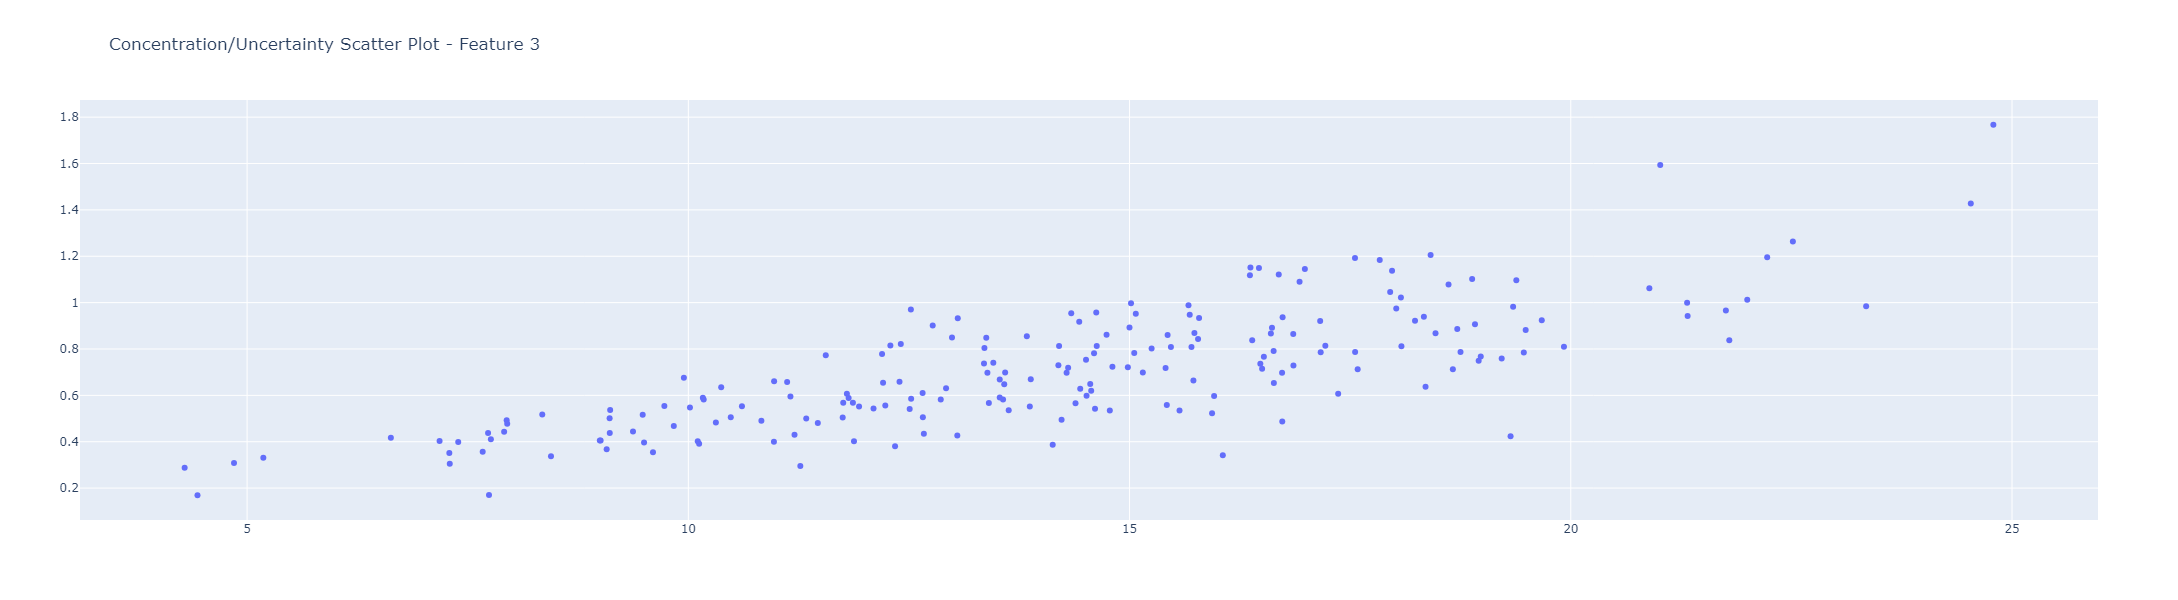

In [9]:
# Concentration / Uncertainty Scatter plot for specific feature, feature/column specified by index
data_handler.plot_data_uncertainty(feature_idx=2)

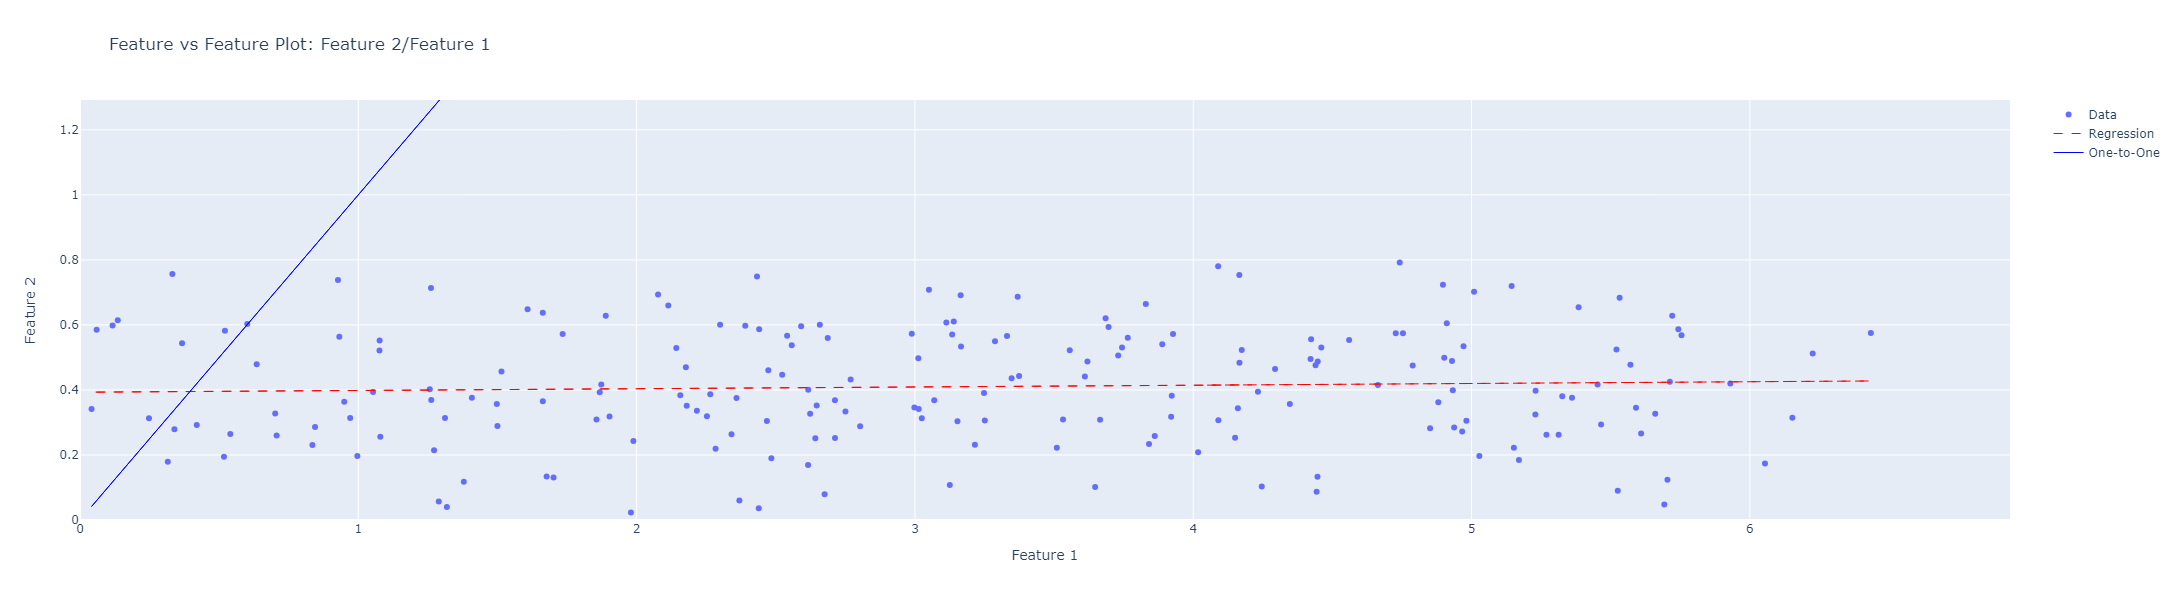

In [10]:
# Species Concentration plot comparing features, features/columns specified by index
data_handler.plot_feature_data(x_idx=0, y_idx=1)

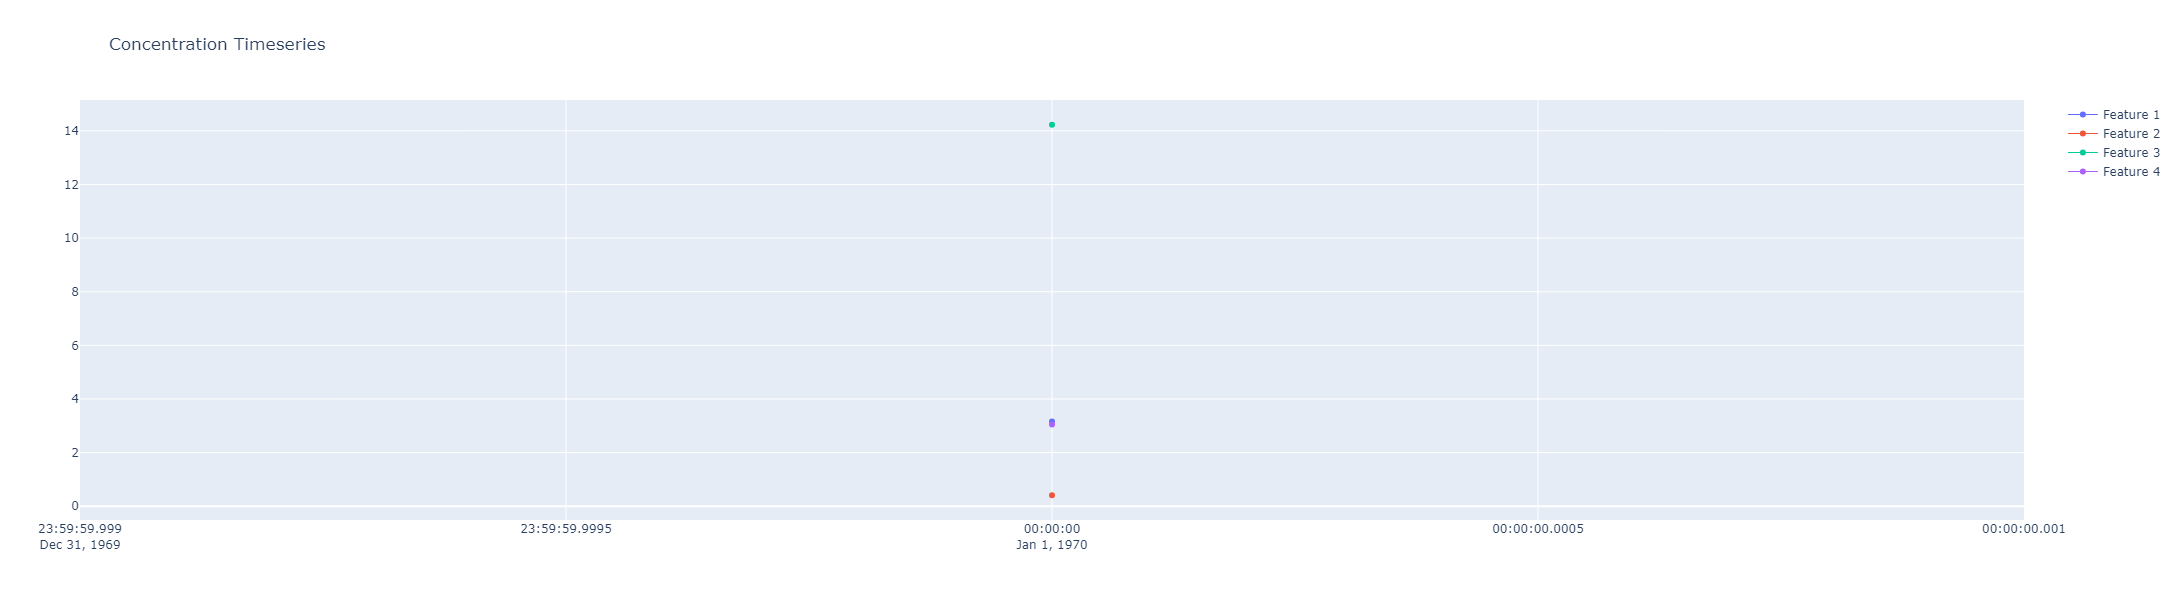

In [11]:
# Species Timeseries, a single or list of features/columns specified by index
data_handler.plot_feature_timeseries(feature_selection=[0, 1, 2, 3])

In [12]:
%%time
# Training multiple models, optional parameters are commented out.
sa_models = BatchSA(V=V, U=U, factors=factors, models=models, method=method, seed=seed, max_iter=max_iterations,
                    init_method=init_method, init_norm=init_norm,
                    converge_delta=converge_delta, converge_n=converge_n, 
                    parallel=parallel, optimized=optimized,
                    verbose=verbose
                   )
_ = sa_models.train()

29-Apr-24 14:45:47 - Model: 1, Q(true): 75847.1293, Q(robust): 42820.3925, Seed: 8925, Converged: True, Steps: 2004/20000
29-Apr-24 14:45:47 - Model: 2, Q(true): 75737.2246, Q(robust): 42655.8369, Seed: 77395, Converged: True, Steps: 1328/20000
29-Apr-24 14:45:47 - Model: 3, Q(true): 75835.4437, Q(robust): 42826.5676, Seed: 65457, Converged: True, Steps: 1270/20000
29-Apr-24 14:45:47 - Model: 4, Q(true): 82255.5992, Q(robust): 47267.3359, Seed: 43887, Converged: True, Steps: 2128/20000
29-Apr-24 14:45:47 - Model: 5, Q(true): 72543.6438, Q(robust): 40601.1527, Seed: 43301, Converged: True, Steps: 2496/20000
29-Apr-24 14:45:47 - Model: 6, Q(true): 76021.0311, Q(robust): 42912.4933, Seed: 85859, Converged: True, Steps: 2095/20000
29-Apr-24 14:45:47 - Model: 7, Q(true): 72714.5268, Q(robust): 40946.0604, Seed: 8594, Converged: True, Steps: 2609/20000
29-Apr-24 14:45:47 - Model: 8, Q(true): 72239.3869, Q(robust): 40832.6246, Seed: 69736, Converged: True, Steps: 1874/20000
29-Apr-24 14:45:47

CPU times: total: 156 ms
Wall time: 7.29 s


#### Train Model

In [13]:
# Selet the best performing model to review
best_model = sa_models.best_model
sa_model = sa_models.results[best_model]
best_model

9

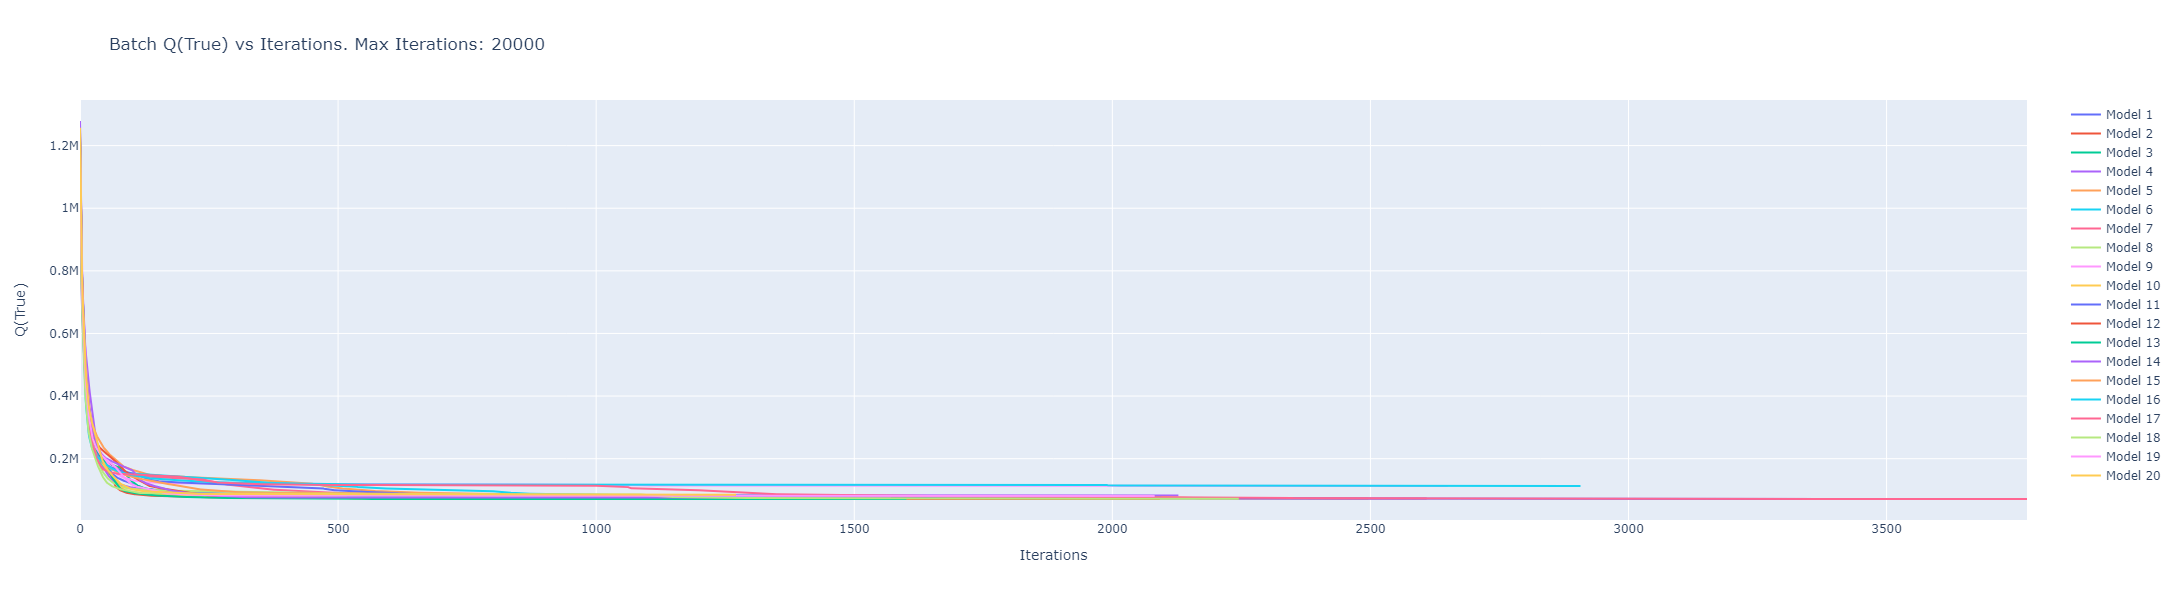

In [14]:
# Perform batch model analysis
batch_analysis = BatchAnalysis(batch_sa=sa_models)
# Plot the loss of the models over iterations
batch_analysis.plot_loss()

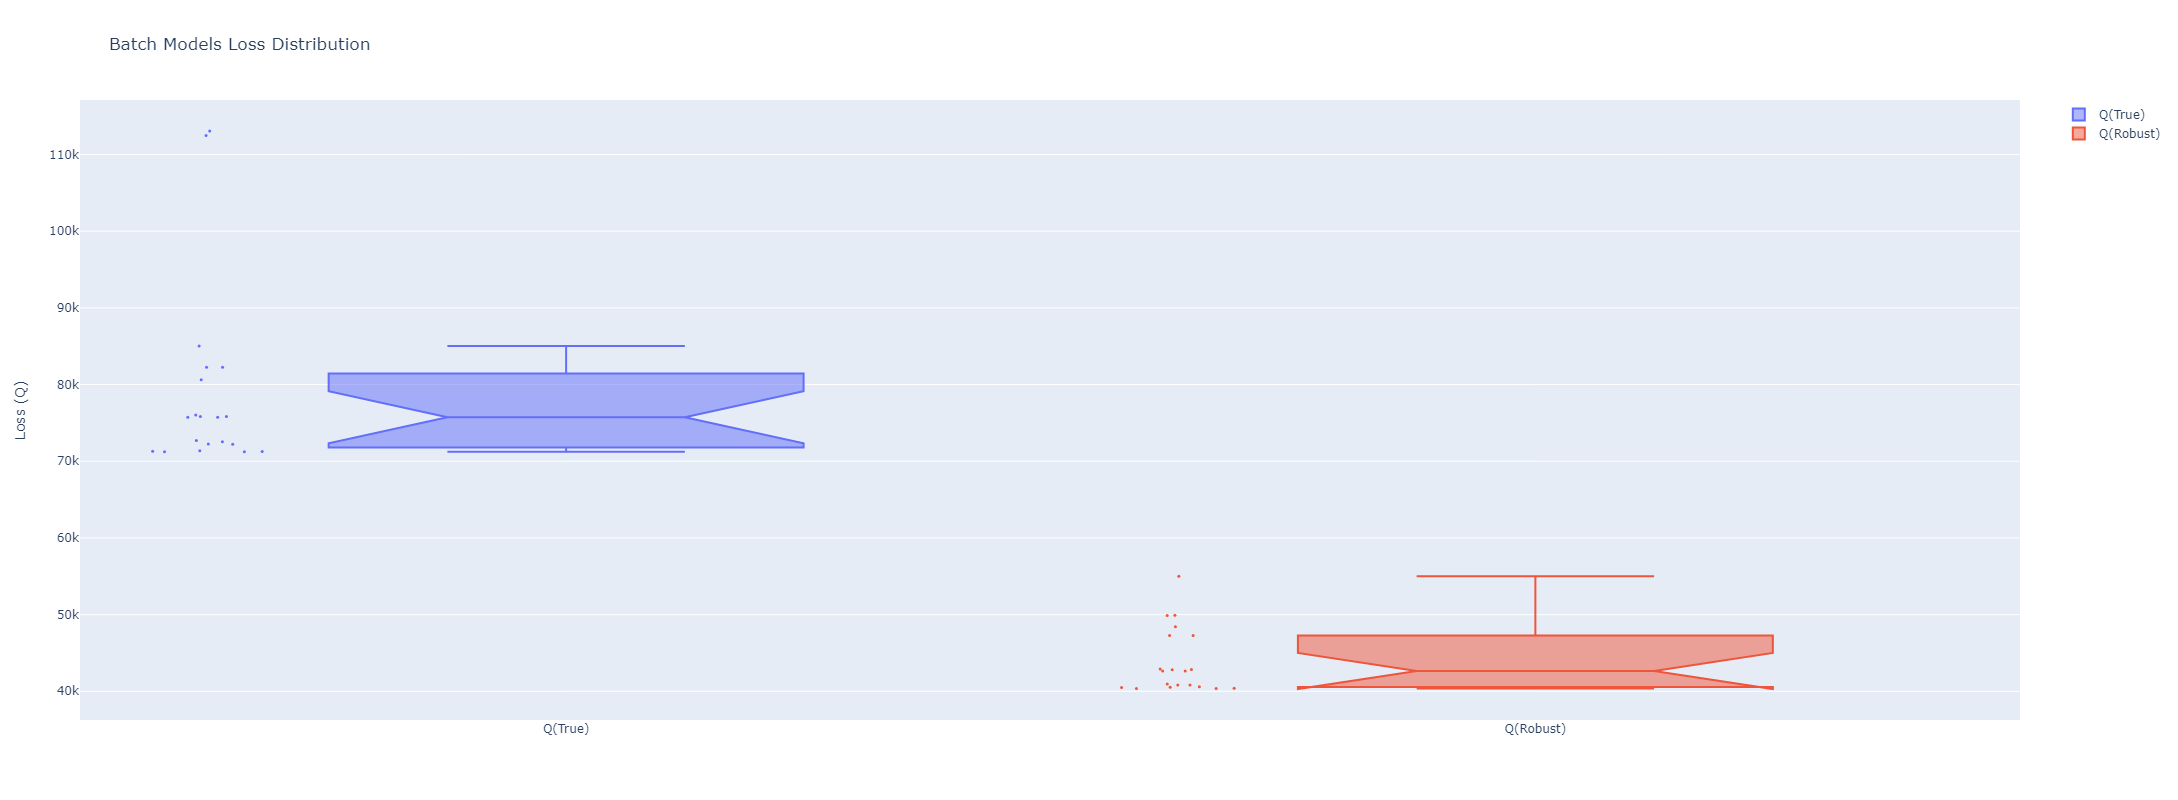

In [15]:
# Plot the loss distribution for the batch models
batch_analysis.plot_loss_distribution()

In [16]:
# Initialize the Model Analysis module
model_analysis = ModelAnalysis(datahandler=data_handler, model=sa_model, selected_model=best_model)

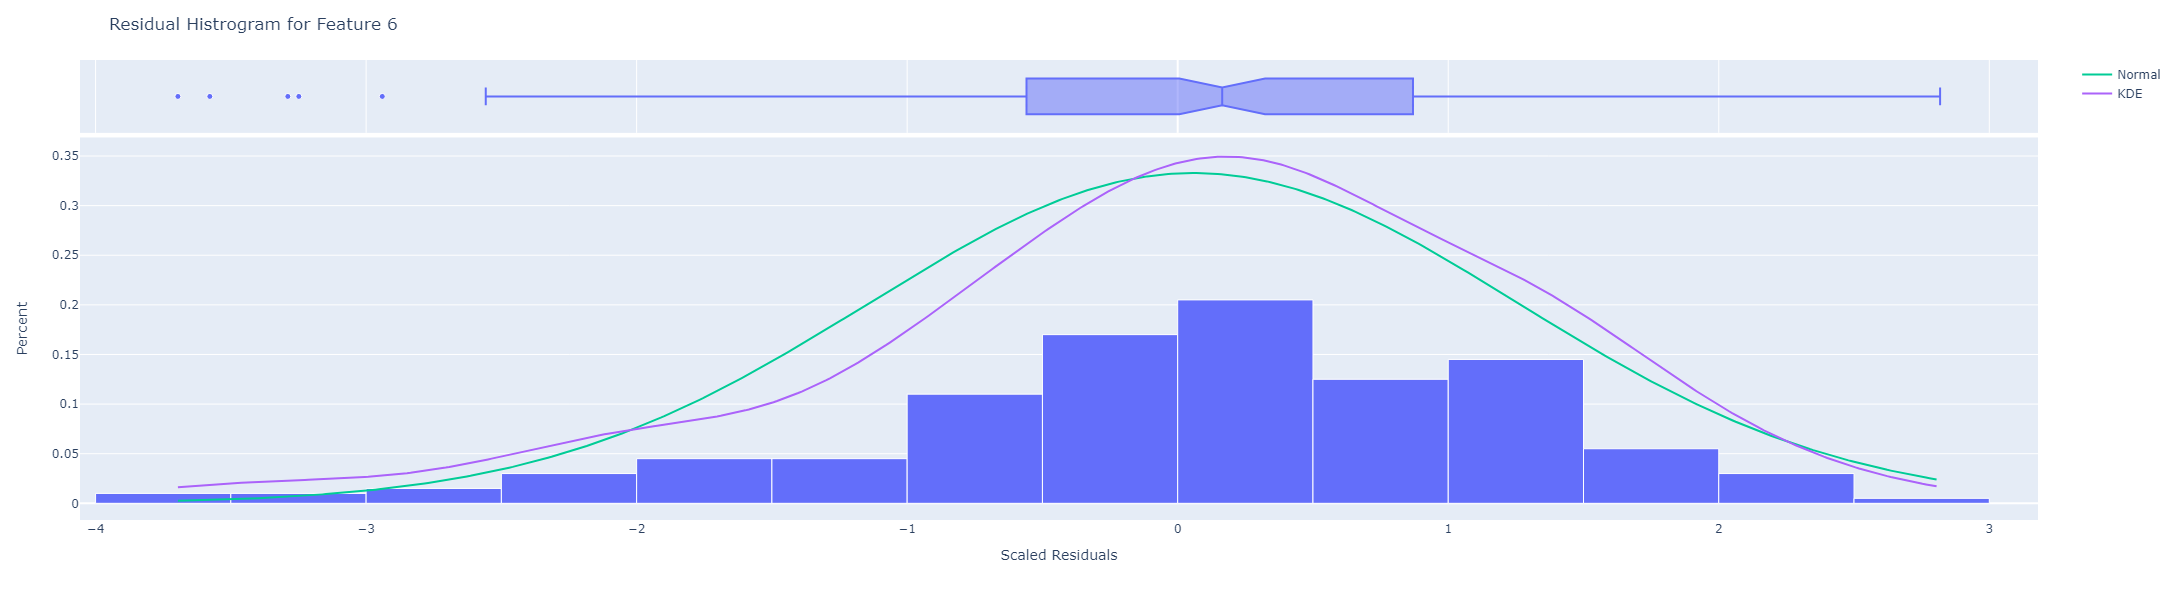

In [17]:
# Residual Analysis shows the scaled residual histogram, along with metrics and distribution curves. The abs_threshold parameter specifies the condition for the returned values of the function call as those residuals which exceed the absolute value of that threshold.
abs_threshold = 3.0
threshold_residuals = model_analysis.plot_residual_histogram(feature_idx=5, abs_threshold=abs_threshold)

In [18]:
print(f"List of Absolute Scaled Residual Greather than: {abs_threshold}. Count: {threshold_residuals.shape[0]}")
threshold_residuals

List of Absolute Scaled Residual Greather than: 3.0. Count: 4


Feature 6  datetime
24   -3.248648        24
42   -3.289352        42
108  -3.577621       108
121  -3.695693       121

In [19]:
# The model output statistics for the estimated V, including SE: Standard Error metrics, and 3 normal distribution tests of the residuals (KS Normal is used in PMF5)
model_analysis.calculate_statistics()
model_analysis.statistics

Features Category        r2  Intercept  Intercept SE     Slope  \
0    Feature 1   strong  0.439136   0.504160      0.178839  0.625714   
1    Feature 2   strong  0.979566   0.008539      0.004444  0.968920   
2    Feature 3   strong  0.879387   0.504879      0.371676  0.955548   
3    Feature 4   strong  0.521883   0.675242      0.137376  0.564145   
4    Feature 5   strong  0.844688   0.983108      0.412184  0.900812   
5    Feature 6   strong  0.988509   0.037199      0.022228  0.976917   
6    Feature 7   strong  0.970149   0.110451      0.114040  0.980464   
7    Feature 8   strong  0.971102   0.156438      0.050377  0.948872   
8    Feature 9   strong  0.971846   0.282420      0.141085  0.968231   
9   Feature 10   strong  0.806141   1.469370      0.439512  0.854796   
10  Feature 11   strong  0.878103   1.084468      0.358359  0.899366   
11  Feature 12   strong  0.926609  -0.203829      0.210138  1.009862   
12  Feature 13   strong  0.972616   0.330969      0.098645  0.952416   
13  Feature 14   strong  0.874864  -1.335462      0.426917  1.082827   
14  Feature 15   strong  0.946838  -0.172468      0.198710  1.012483   
15  Feature 16   strong  0.953476   0.585844      0.184106  0.944549   
16  Feature 17   strong  0.704154   1.250252      0.375449  0.803873   
17  Feature 18   strong  0.896856   0.870440      0.371144  0.927515   
18  Feature 19   strong  0.985823   0.057836      0.041469  0.981849   
19  Feature 20   strong  0.922145   0.594955      0.333625  0.953650   
20  Feature 21   strong  0.964759   0.149061      0.071987  0.952383   
21  Feature 22   strong  0.927886   1.012907      0.361998  0.934025   
22  Feature 23   strong  0.946028   0.502999      0.217586  0.950427   
23  Feature 24   strong  0.928870  -0.426269      0.238594  1.035443   
24  Feature 25   strong  0.801713   1.974142      0.555543  0.858291   
25  Feature 26   strong  0.973372   0.162402      0.058936  0.956220   
26  Feature 27   strong  0.987463   0.082787      0.048177  0.976153   
27  Feature 28   strong  0.971700   0.120208      0.072180  0.973071   
28  Feature 29   strong  0.979968   0.025949      0.010587  0.962593   
29  Feature 30   strong  0.967361   0.026049      0.012515  0.952042   
30  Feature 31   strong  0.965769   0.506310      0.133215  0.940418   
31  Feature 32   strong  0.845683   1.782550      0.514089  0.873265   
32  Feature 33   strong  0.951660  -0.254033      0.274537  1.009748   
33  Feature 34   strong  0.889441   0.335038      0.154975  0.923056   
34  Feature 35   strong  0.994026   0.001569      0.002658  0.992338   
35  Feature 36   strong  0.975367  -0.019309      0.054347  0.994032   
36  Feature 37   strong  0.980017   0.094253      0.086492  0.983808   
37  Feature 38   strong  0.529543   0.641199      0.136846  0.568432   
38  Feature 39   strong  0.978922  -0.045552      0.052717  1.004916   
39  Feature 40   strong  0.581439   1.837870      0.345807  0.674215   

    Slope SE        SE  SE Regression Anderson Normal Residual  \
0   0.050254  0.092433       1.155337                       No   
1   0.009945  0.001802       0.024881                     15.0   
2   0.025149  0.100805       1.414484                       No   
3   0.038374  0.091861       1.010890                       No   
4   0.027451  0.132103       1.809519                       No   
5   0.007485  0.011675       0.161289                       No   
6   0.012222  0.035835       0.503548                     15.0   
7   0.011633  0.018667       0.251988                     15.0   
8   0.011712  0.050284       0.698270                     15.0   
9   0.029790  0.139835       1.868629                     15.0   
10  0.023814  0.113628       1.539033                       No   
11  0.020198  0.056838       0.803334                       No   
12  0.011357  0.038582       0.522944                     15.0   
13  0.029104  0.146384       2.029097                       No   
14  0.017050  0.056752       0.801506                       No 

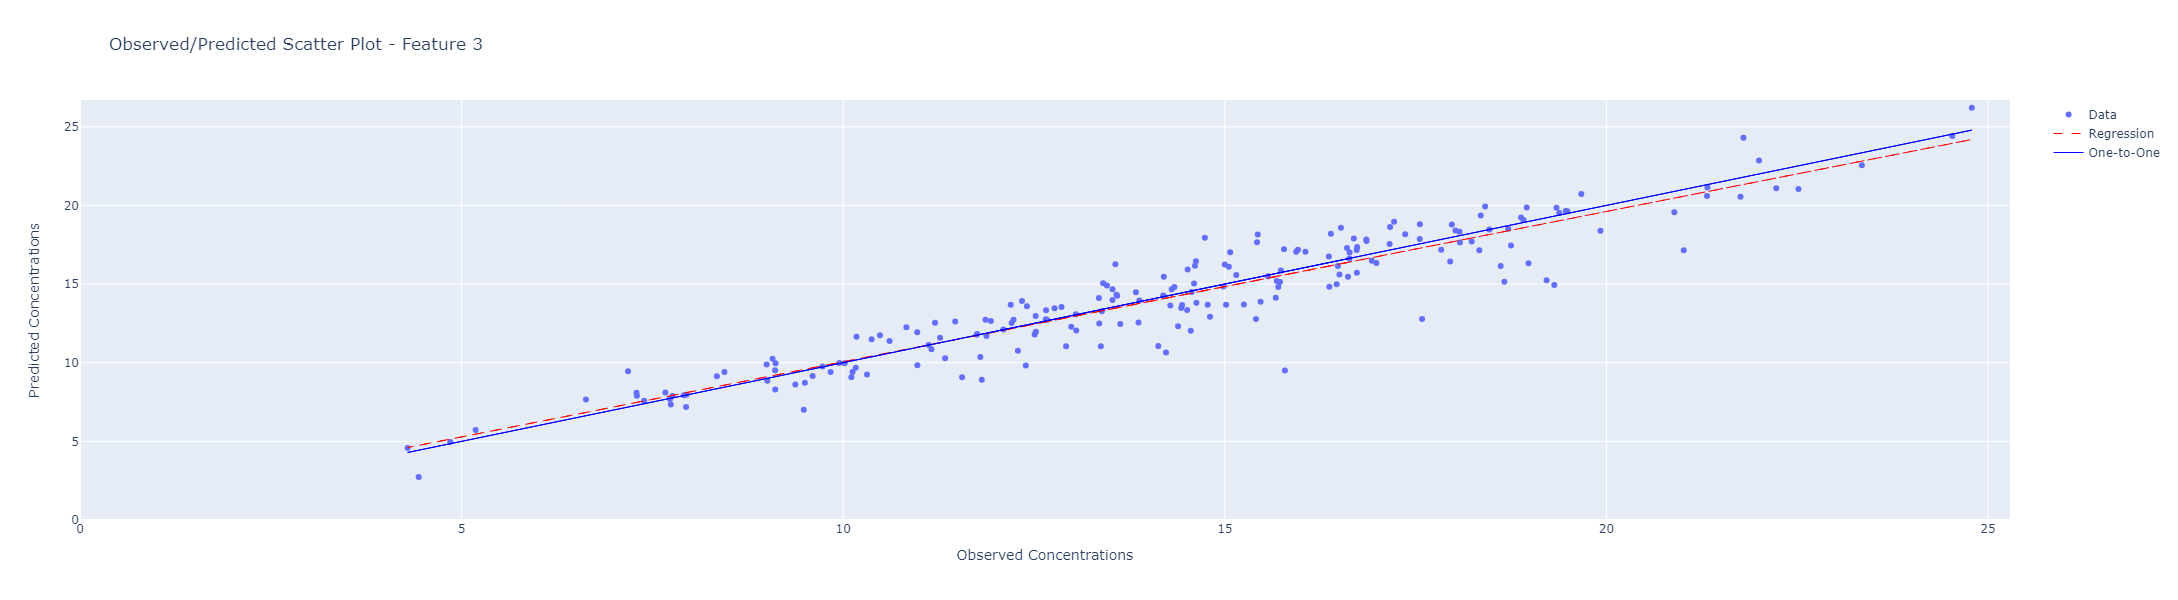

In [20]:
# Model feature observed vs predicted plot with regression and one-to-one lines. Feature/Column specified by index.
model_analysis.plot_estimated_observed(feature_idx=2)

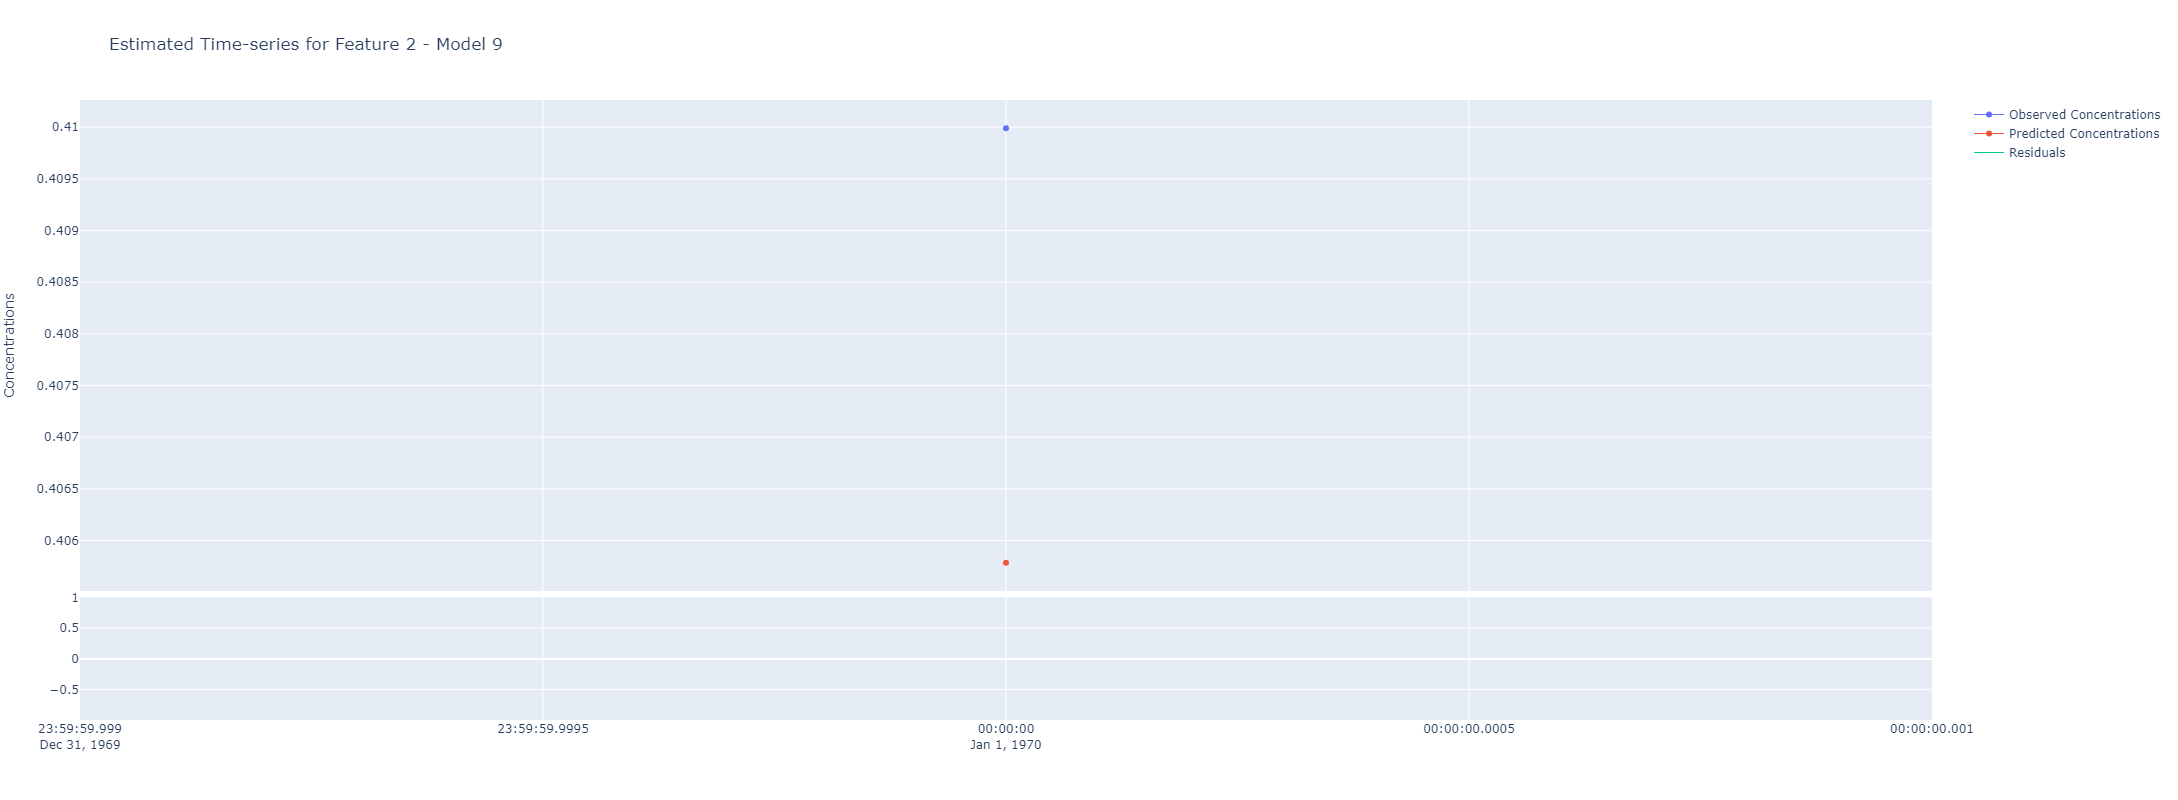

In [21]:
# Model feature timeseries analysis plot showing the observed vs predicted values of the feature, along with the residuals shown below. Feature/column specified by index.
model_analysis.plot_estimated_timeseries(feature_idx=1)

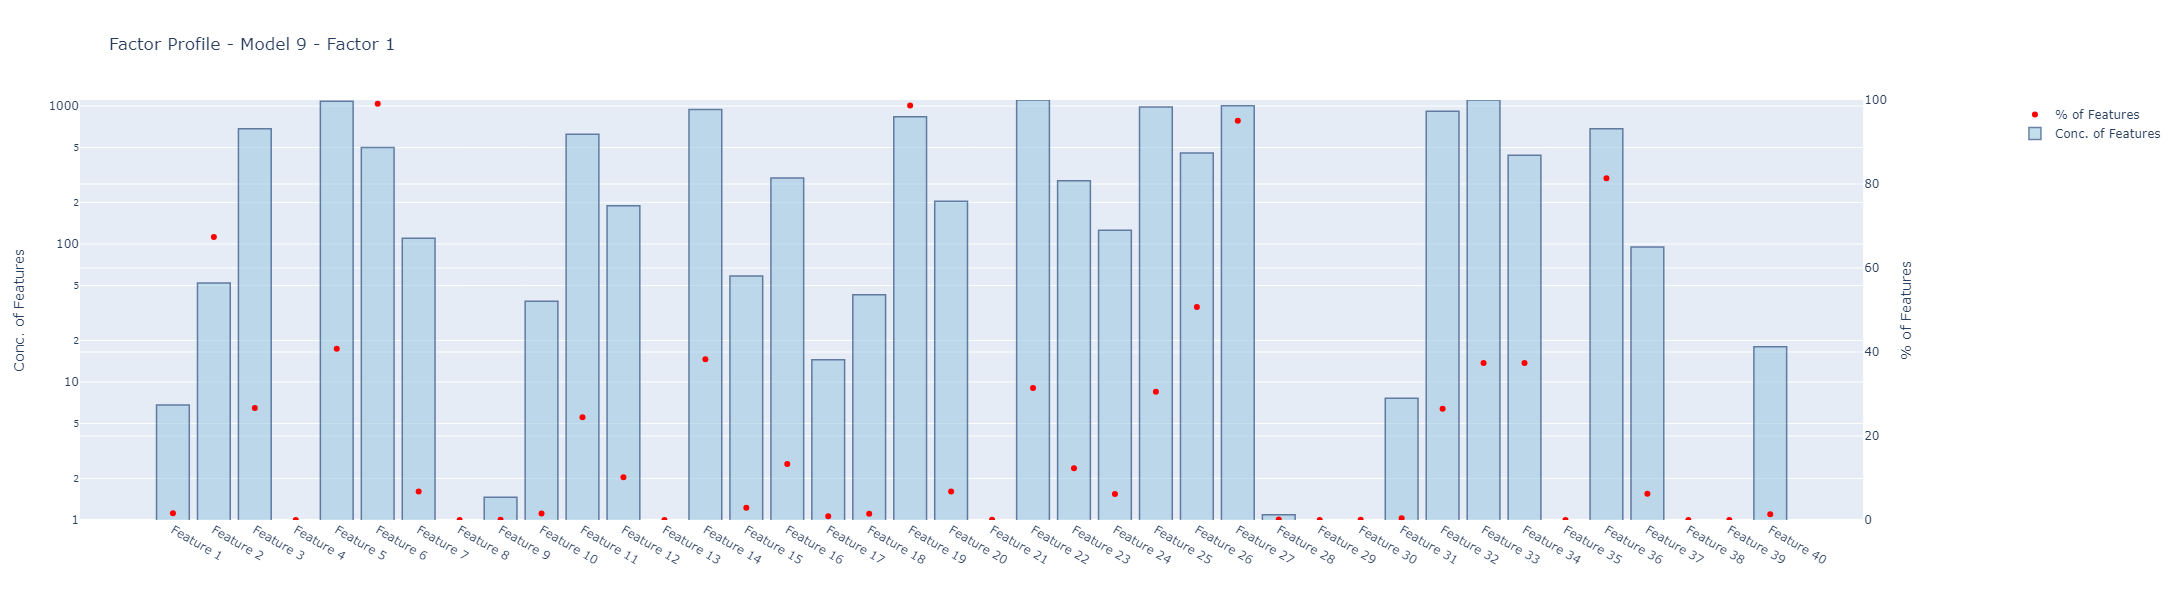

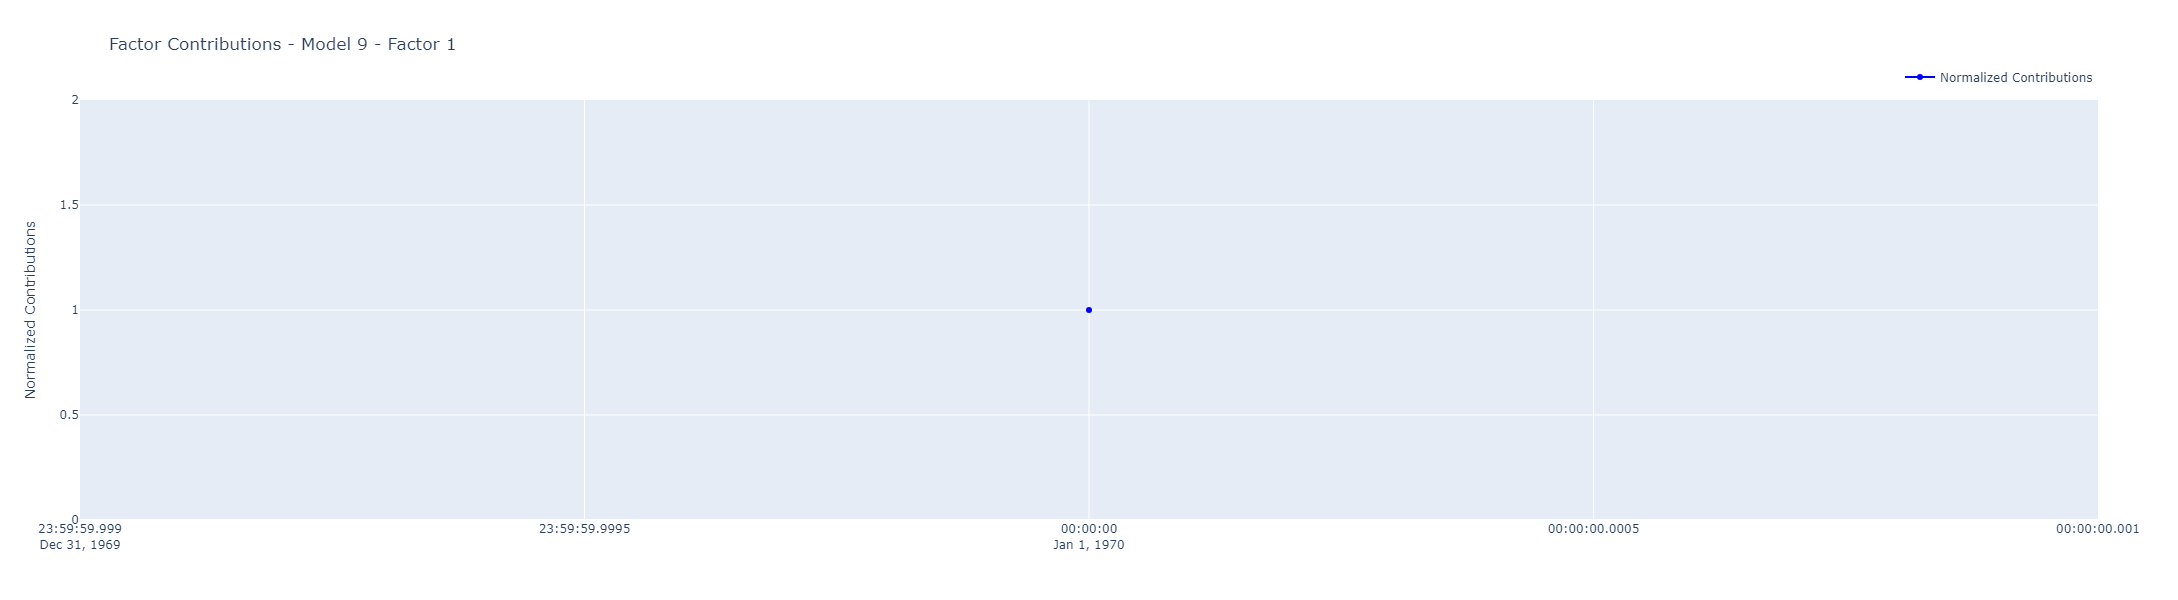

In [22]:
# Factor profile plot showing the factor sum of concentrations by feature (blue bars), the percentage of the feature as the red dot, and in the bottom plot the normalized contributions by date (values are resampled at a daily timestep for timeseries consistency).
# Factor specified by index.
model_analysis.plot_factor_profile(factor_idx=1)

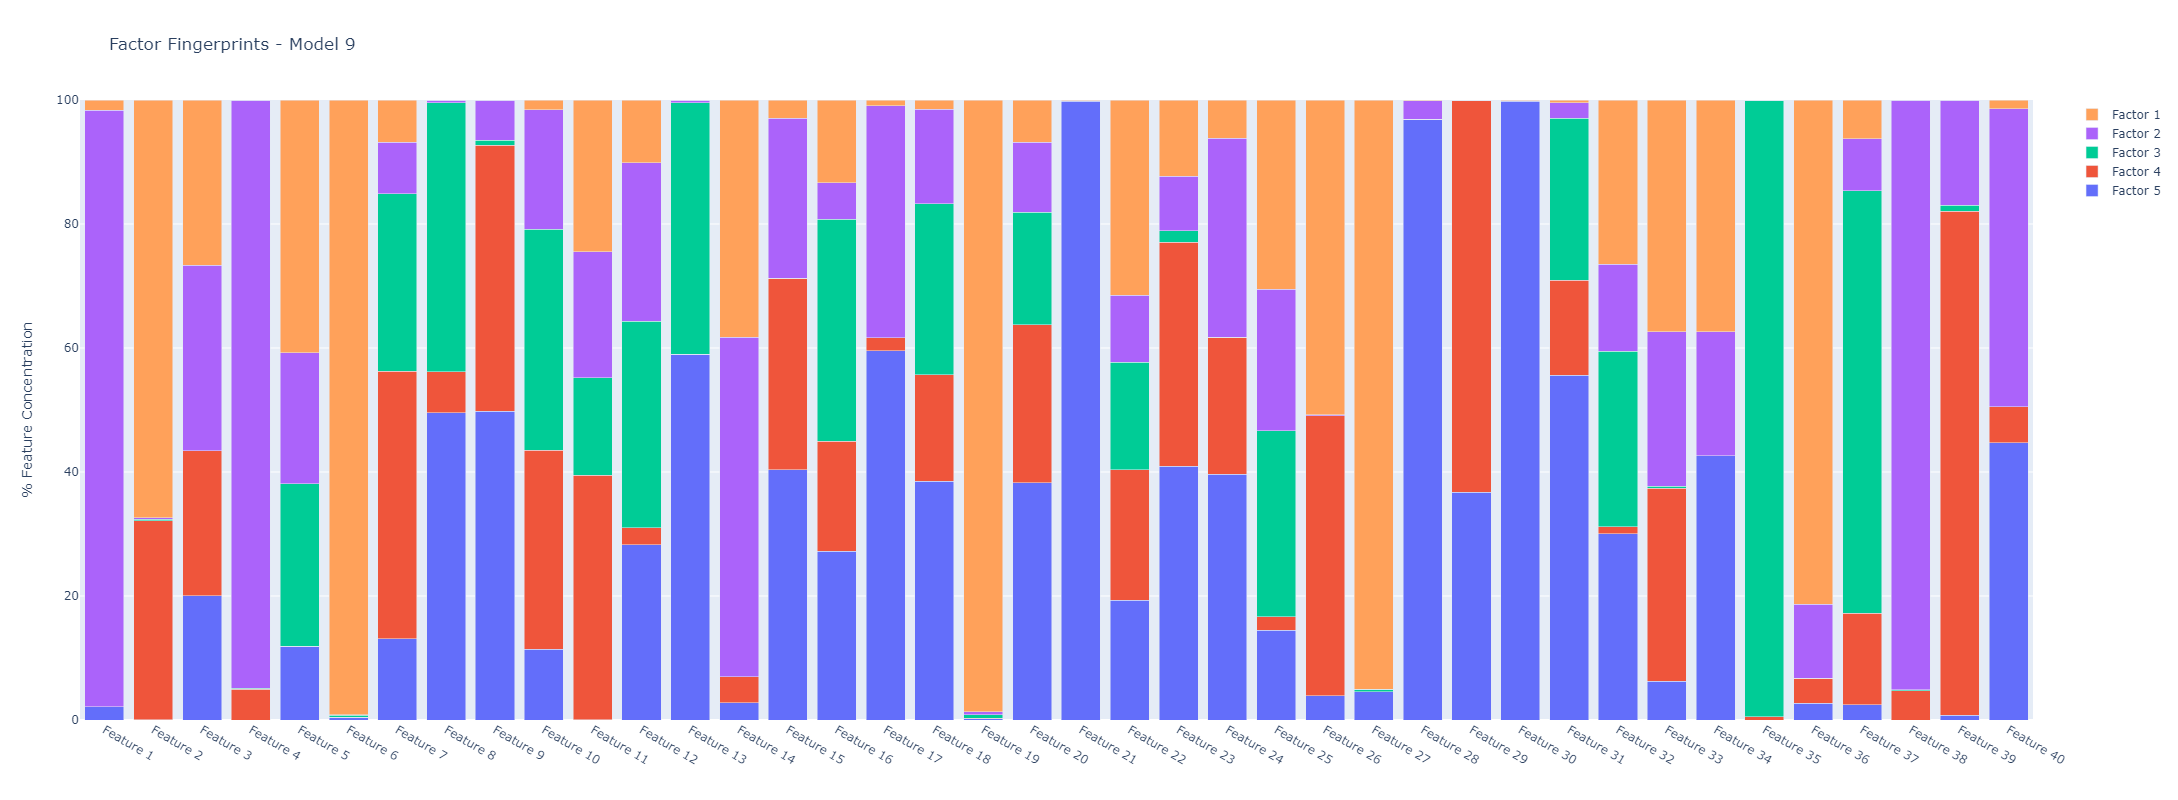

In [23]:
# Model factor fingerprint specifies the feature percentage of each factor.
model_analysis.plot_factor_fingerprints()

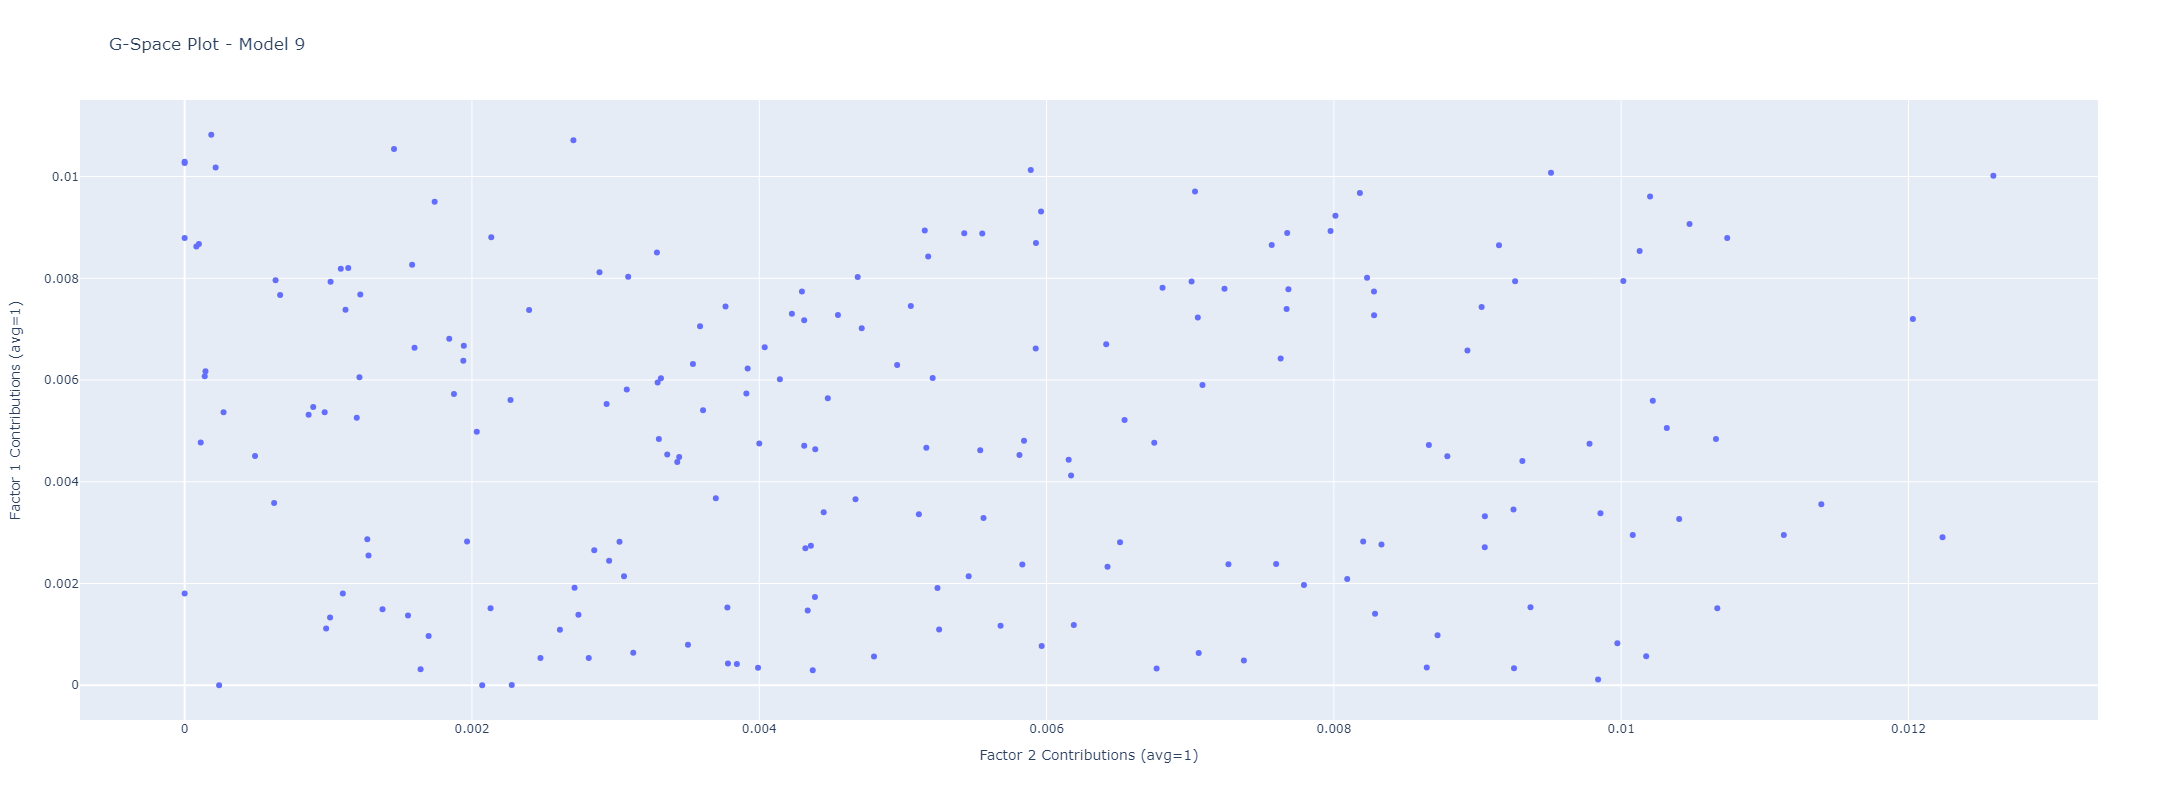

In [24]:
# Factor G-Space plot shows the normalized contributions of one factor vs another factor. Factor specified by index.
model_analysis.plot_g_space(factor_1=2, factor_2=1)

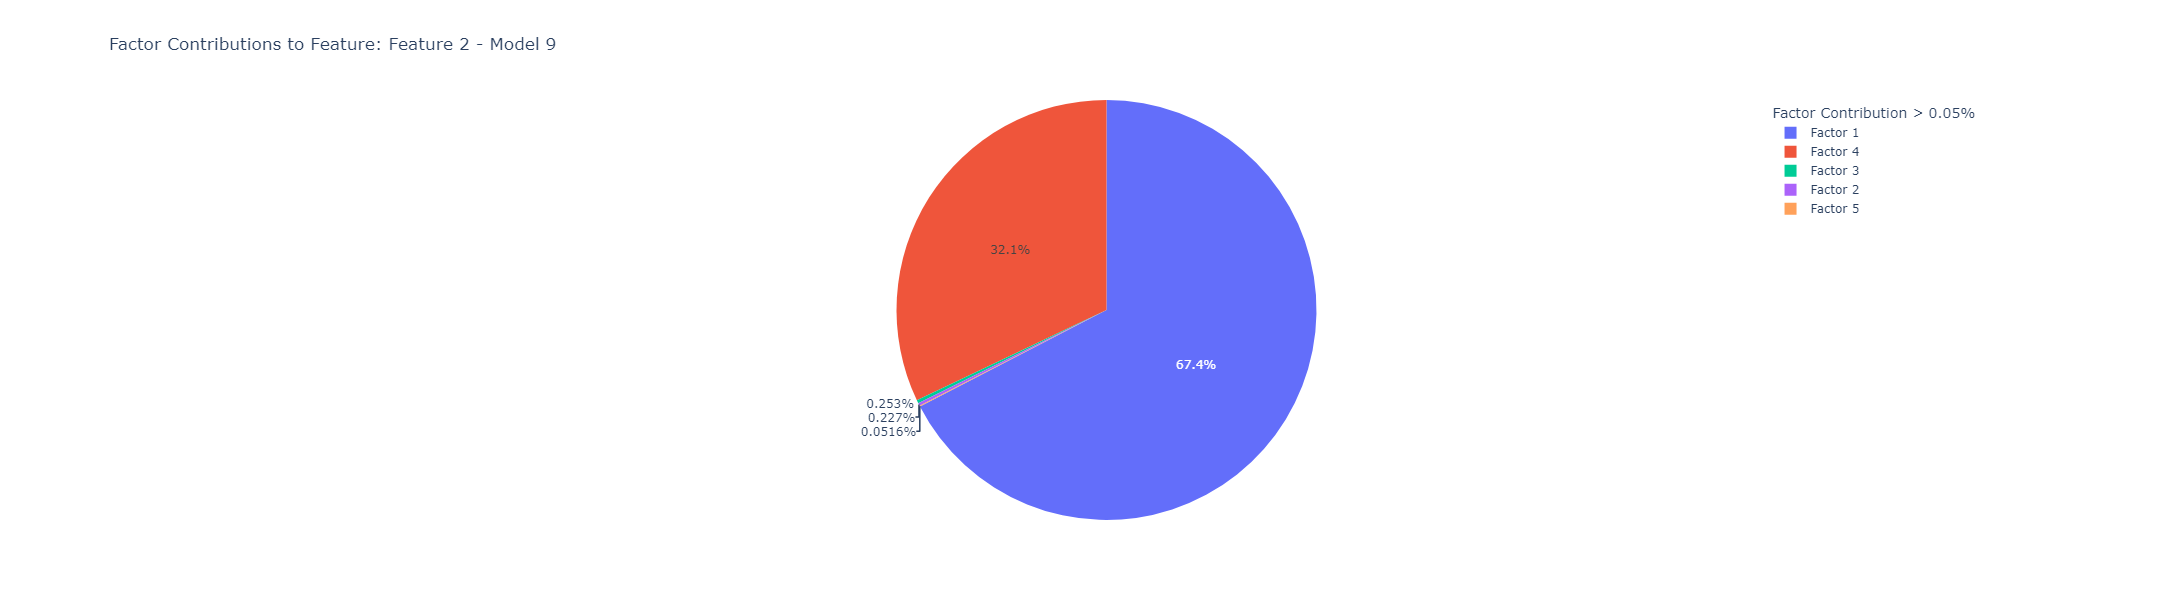

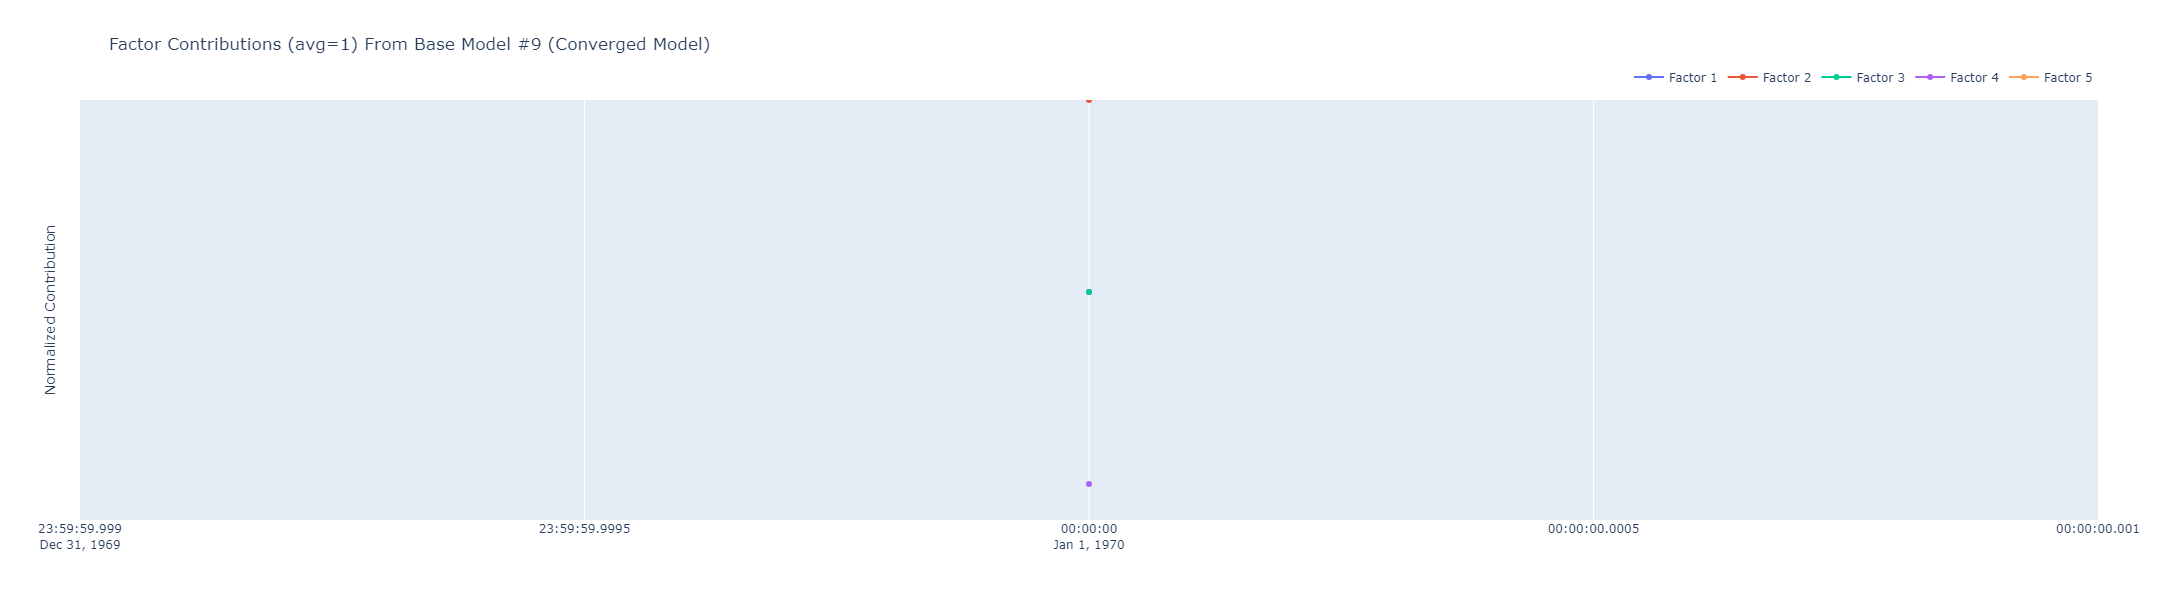

In [25]:
# Factor contribution pie chart shows the percentage of factor contributions for the specified feature, and the corresponding normalized contribution of each factor for that feature (bottom plot). Feature specified by index.
model_analysis.plot_factor_contributions(feature_idx=1)

### Compare to Synthetic Data

Compare the set of batch models to the original synthetic factor data.


In [26]:
from eval.factor_comparison import FactorCompare

In [27]:
factor_comp = FactorCompare(input_df=data_handler.input_data, uncertainty_df=data_handler.uncertainty_data, base_profile_df=syn_profile_df, base_contribution_df=syn_contribution_df, batch_sa=sa_models)

In [28]:
factor_comp.compare()

Calculating correlation between base and model factors: 100%|█████████████████████████████████████████████████████| 600/600 [00:00<00:00, 781.66it/s]
29-Apr-24 14:45:51 - Model Count: 20, Correlation Count: 30
Calculating average correlation for all permutations for Mode: 20: 100%|██████████████████████████████████████| 14400/14400 [01:28<00:00, 162.70it/s]
29-Apr-24 14:47:20 - R2 - Model: 16, Best permutations: ['Factor 4', 'Factor 6', 'Factor 5', 'Factor 3', 'Factor 1'], Average R2: 0.9187383991331123, 
Profile R2 Avg: 0.9545577467193123, Contribution R2 Avg: 0.8889045549803548, WH R2 Avg: 0.9127528956996696
Profile R2: [0.9396371284455723, 0.9891725007756247, 0.9789961112761418, 0.8827914250543595, 0.9821915680448631], 
Contribution R2: [0.9721015855885782, 0.9967161837596218, 0.9653598176781916, 0.5230555358146762, 0.9872896520607066], 
WH R2: [0.9374501884583137, 0.9897086569742708, 0.9682692379307277, 0.6894924162666202, 0.978843978868415]
29-Apr-24 14:47:20 - Base Q(true): 77.03

In [29]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

Base factors: 6, SA factors: 5. Factor N: 5
Factor Map: ['Factor 4', 'Factor 6', 'Factor 5', 'Factor 3', 'Factor 1']
Syn i: 3, Mod i: 0, Label: ('Modelled Factor 1 : Synthetic Factor Factor 4', '', '')


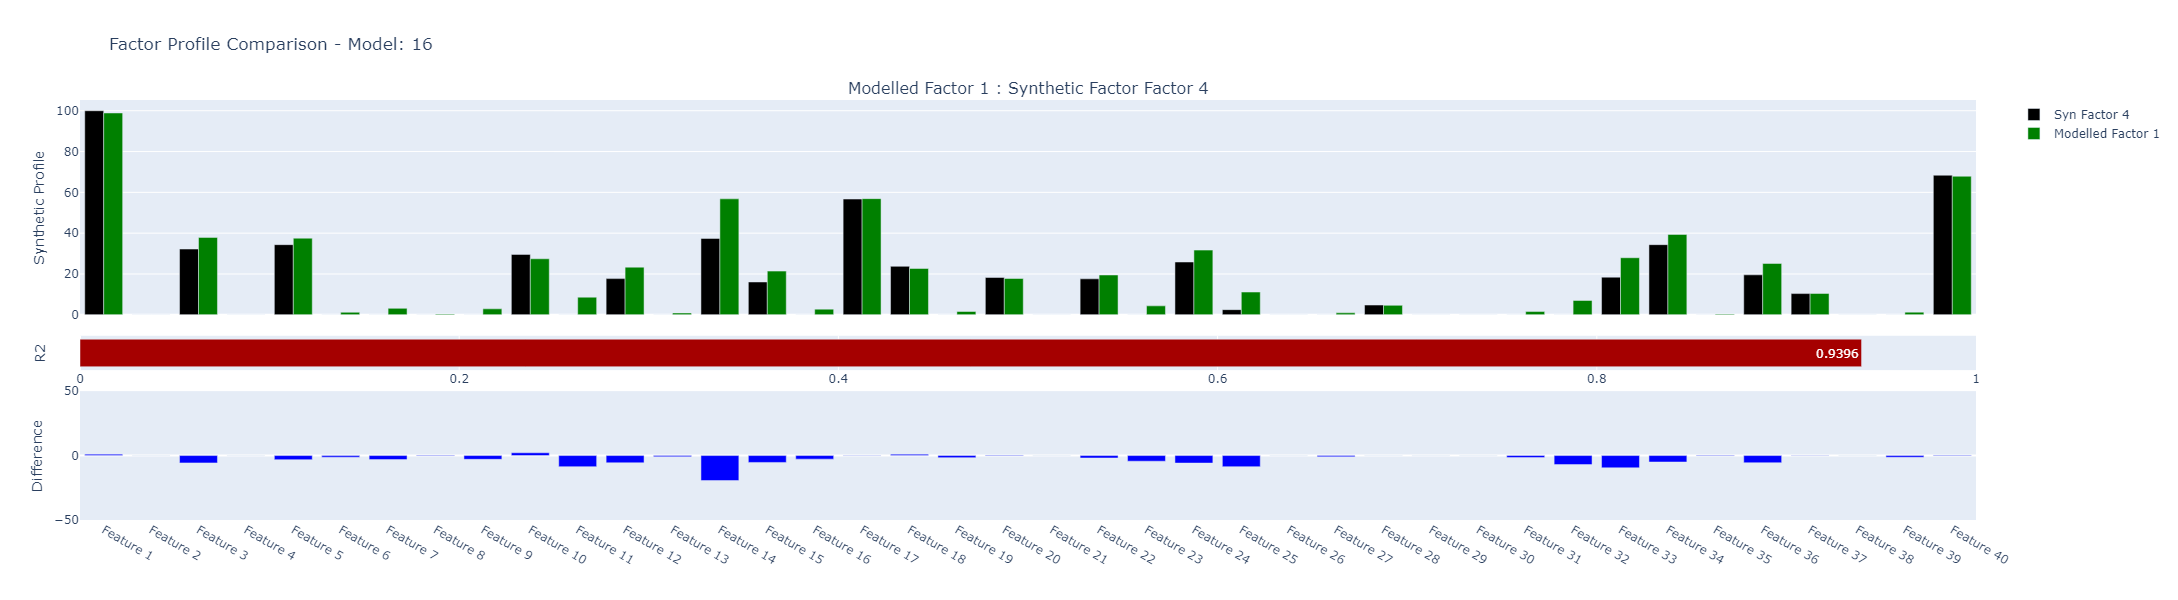

Syn i: 5, Mod i: 1, Label: ('Modelled Factor 2 : Synthetic Factor Factor 6', '', '')


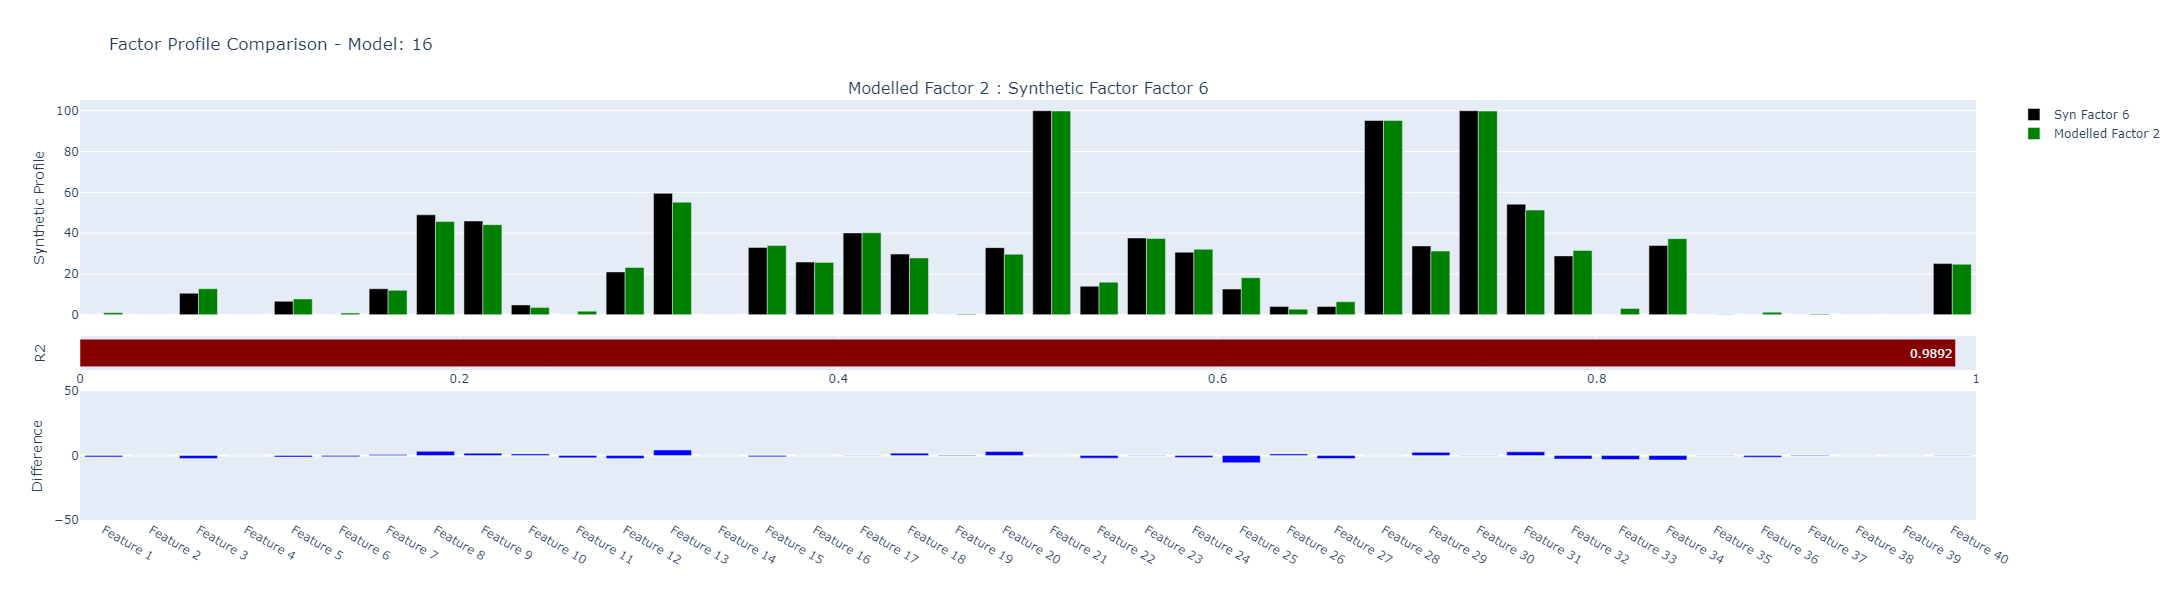

Syn i: 4, Mod i: 2, Label: ('Modelled Factor 3 : Synthetic Factor Factor 5', '', '')


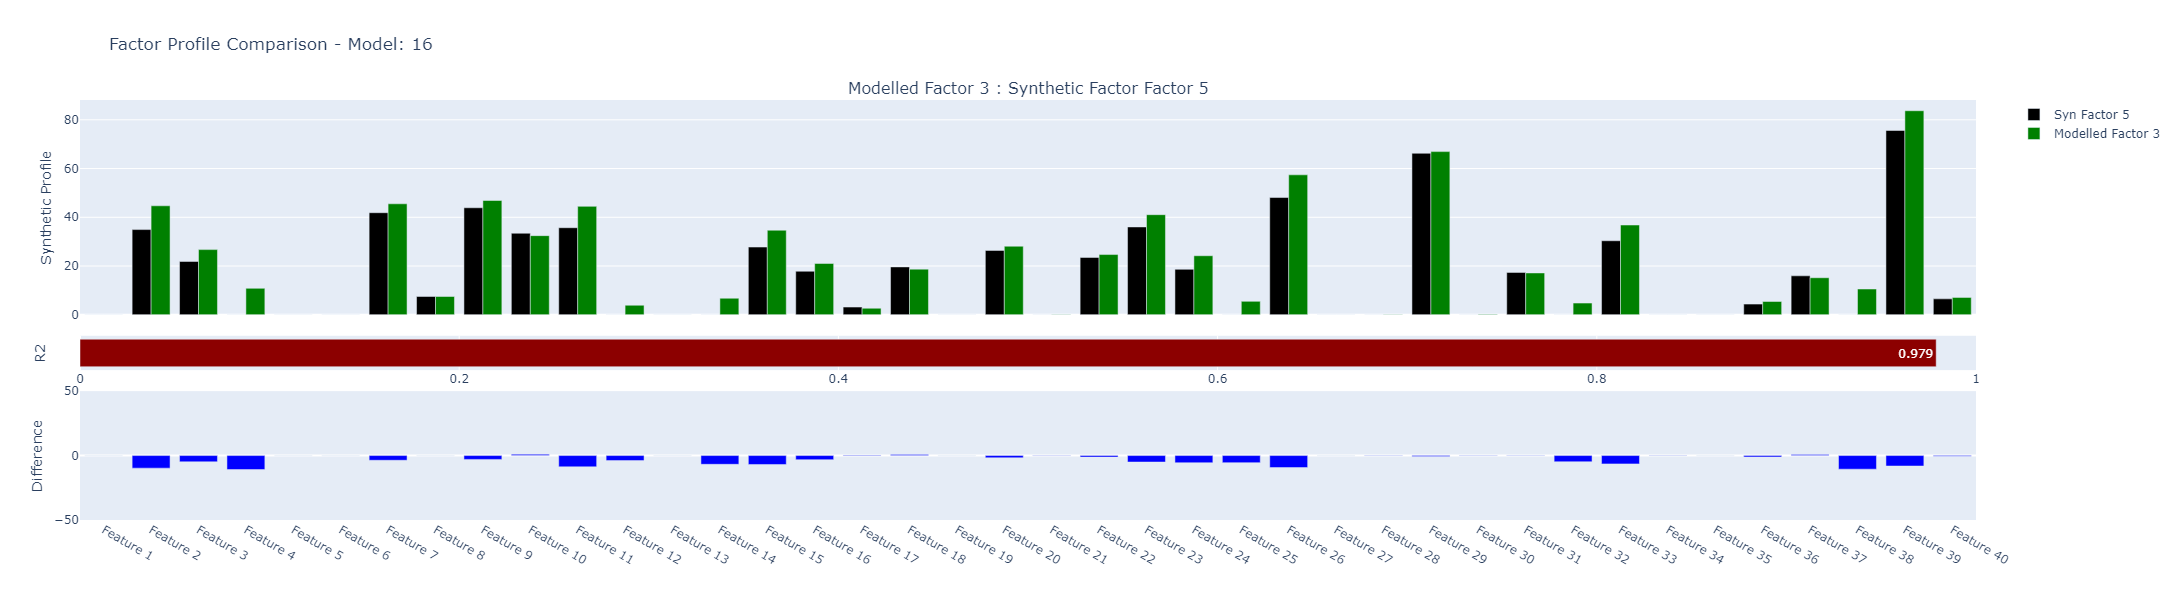

Syn i: 2, Mod i: 3, Label: ('Modelled Factor 4 : Synthetic Factor Factor 3', '', '')


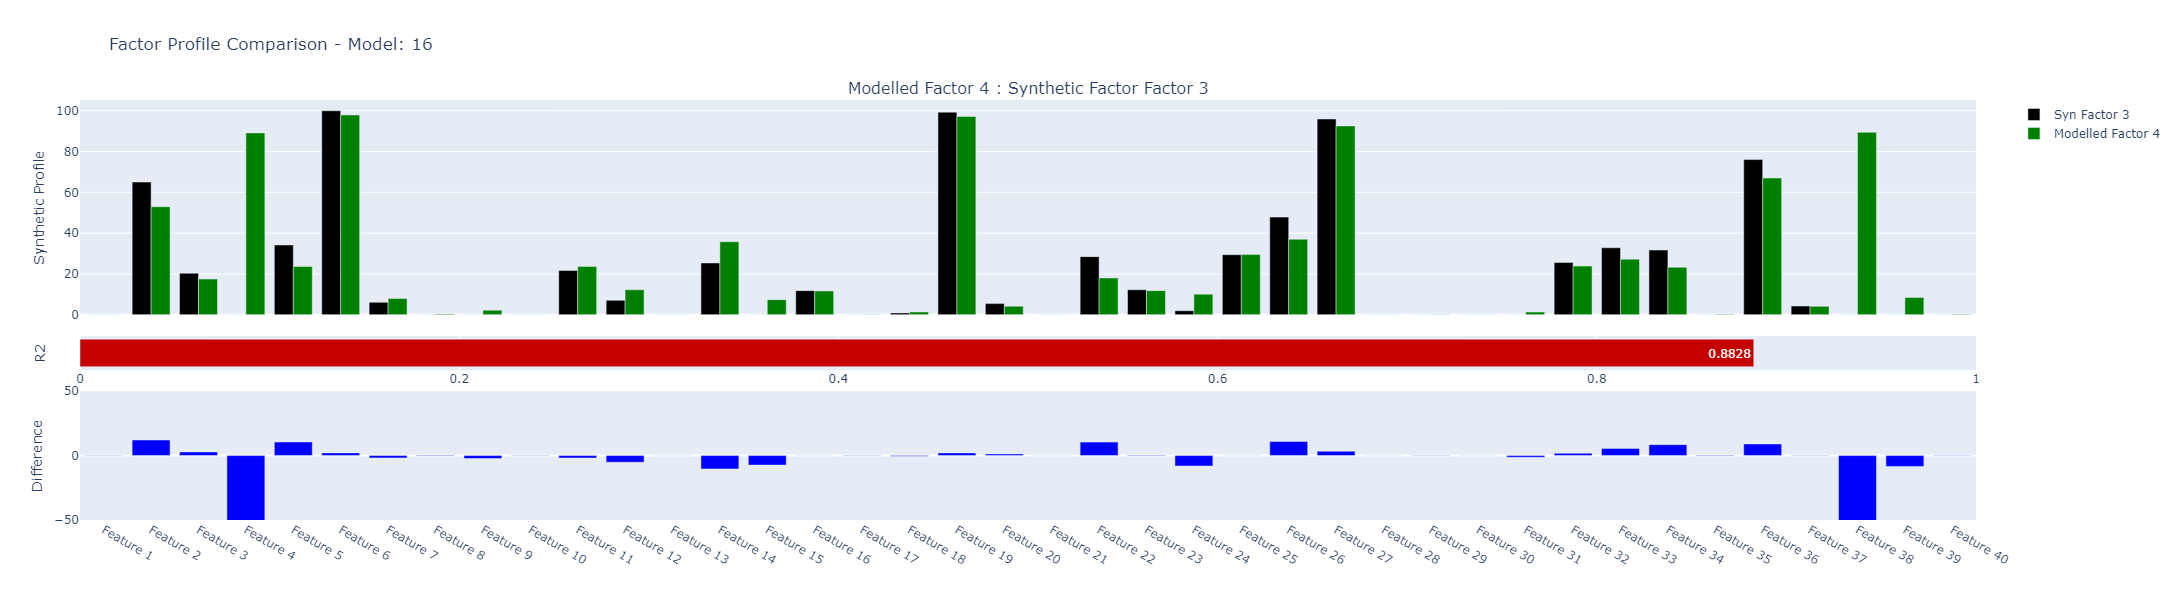

Syn i: 0, Mod i: 4, Label: ('Modelled Factor 5 : Synthetic Factor Factor 1', '', '')


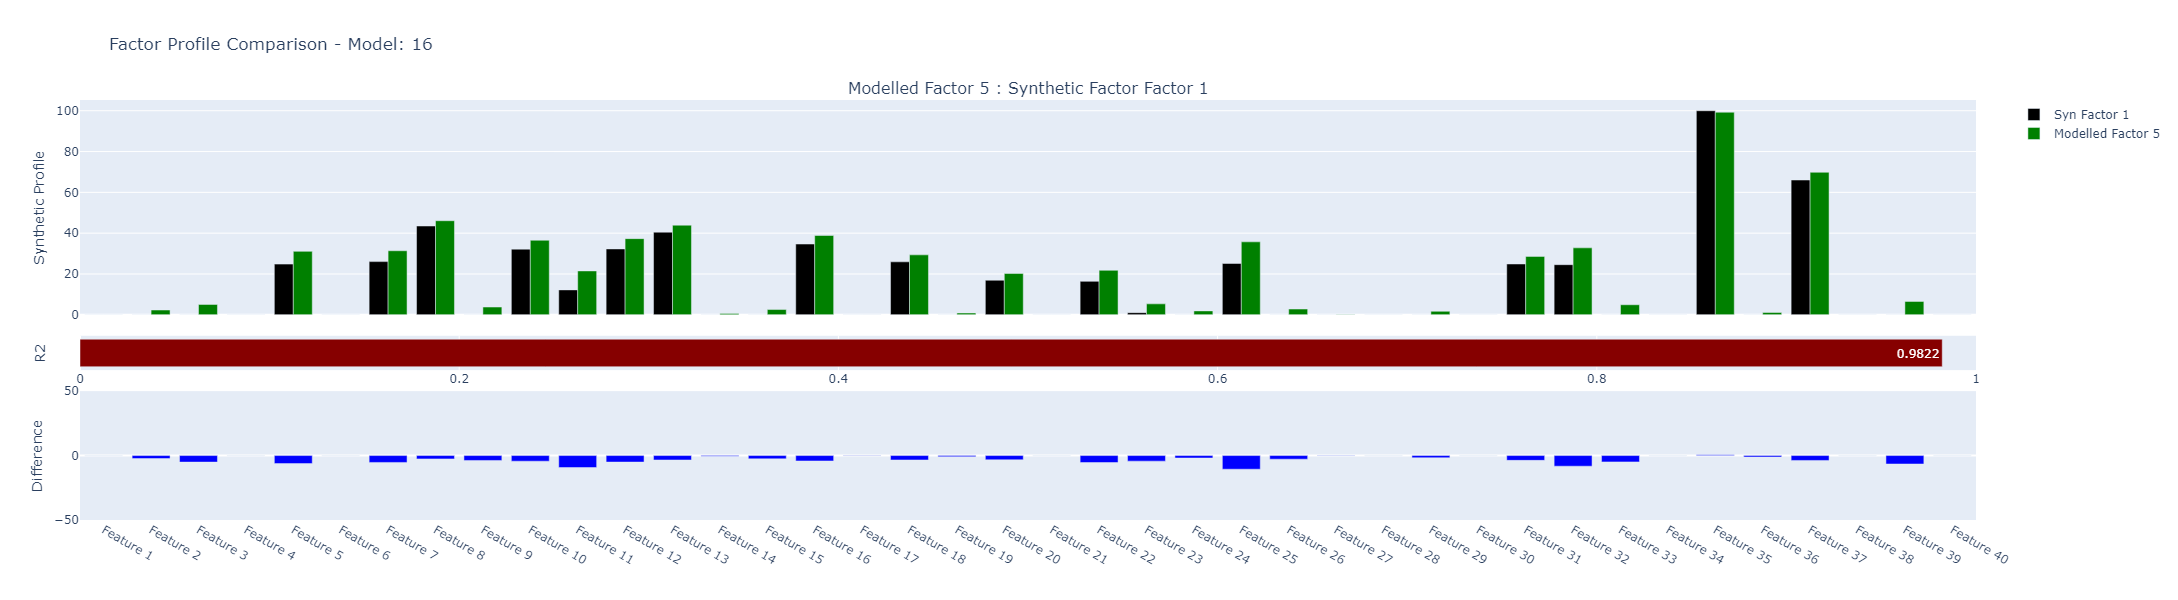

In [48]:
color_map = px.colors.sample_colorscale("plasma", [n/(factors -1) for n in range(factors)])
r_color_map = px.colors.sample_colorscale("jet", [n/(100 -1) for n in range(100)])

c_model = sa_models.results[factor_comp.best_model]
syn_H = syn_factor_profiles
norm_syn_H = 100 * (syn_H / syn_H.sum(axis=0))

_H = sa_models.results[factor_comp.best_model].H
norm_H = 100 * (_H / _H.sum(axis=0))

factor_n = min(len(factor_comp.sa_factors), len(factor_comp.base_factors))
print(f"Base factors: {len(factor_comp.base_factors)}, SA factors: {len(factor_comp.sa_factors)}. Factor N: {factor_n}")
if not factor_comp.base_k:
    subplot_titles = [f"Synthetic Factor {i} : Modelled {factor_comp.factor_map[i-1]}" for i in range(1, factor_n+1)]
else:
    subplot_titles = [f"Modelled Factor {i} : Synthetic Factor {factor_comp.factor_map[i-1]}" for i in range(1, factor_n+1)]
print(f"Factor Map: {factor_comp.factor_map}")
# h_fig = make_subplots(rows=3, cols=factors, vertical_spacing=0.03, subplot_titles=subplot_titles, row_heights=[0.50, 0.04, 0.31])
for i in range(1, factor_n+1):
    label = (subplot_titles[i-1], "", "")
    h_fig = make_subplots(rows=3, cols=1, vertical_spacing=0.05, subplot_titles=label, row_heights=[0.5, 0.08, 0.3])
    map_i = int(factor_comp.factor_map[i-1].split(" ")[1])
    if not factor_comp.base_k:
        syn_i = i - 1
        mod_i = map_i - 1
    else:
        syn_i = map_i - 1
        mod_i = i - 1
    print(f"Syn i: {syn_i}, Mod i: {mod_i}, Label: {label}")

    h_fig.add_trace(go.Bar(name=f"Syn Factor {syn_i+1}", x=data_handler.features, y=norm_syn_H[syn_i], marker_color="black"), row=1, col=1)
    h_fig.add_trace(go.Bar(name=f"Modelled Factor {mod_i+1}", x=data_handler.features, y=norm_H[mod_i], marker_color="green"), row=1, col=1)
    i_r2 = factor_comp.best_factor_r[i-1]
    h_fig.add_trace(go.Bar(name="R2", x=(i_r2,), orientation='h', marker_color=r_color_map[int(100*i_r2)], text=np.round(i_r2,4), textposition="inside", hoverinfo='text', hovertemplate="R2: %{x:4f}<extra></extra>", showlegend=False), row=2, col=1)
    h_fig.add_trace(go.Bar(name="", x=data_handler.features, y=norm_syn_H[syn_i]- norm_H[mod_i], marker_color="blue", showlegend=False), row=3, col=1)
    h_fig.update_yaxes(title_text="Synthetic Profile", row=1, col=1, title_standoff=3)
    # h_fig.update_yaxes(title_text="Model Profile", row=2, col=1, title_standoff=3)
    h_fig.update_yaxes(title_text="R2", row=2, col=1, title_standoff=25)
    h_fig.update_yaxes(title_text="Difference", row=3, col=1, title_standoff=3)
    h_fig.update_xaxes(row=1, showticklabels=False)
    # h_fig.update_xaxes(row=2, showticklabels=False)
    h_fig.update_xaxes(row=2, range=[0, 1.0])
    h_fig.update_yaxes(row=2, showticklabels=False)
    h_fig.update_yaxes(row=3, range=[-50, 50])
    h_fig.update_layout(title_text=f"Factor Profile Comparison - Model: {factor_comp.best_model+1}", width=1000, height=600, hovermode='x', showlegend=True)
    h_fig.show()

In [ ]:
syn_H = syn_factor_profiles
syn_W = syn_factor_contributions

_H = sa_models.results[factor_comp.best_model].H
_W = sa_models.results[factor_comp.best_model].W

syn_matrices = []
pred_matrices = []
for f in range(factors):
    f_sW = syn_W[:, f]
    f_sW = np.reshape(f_sW, (len(f_sW), 1))
    f_sH = [syn_H[f]]
    f_sWH = np.matmul(f_sW, f_sH)
    syn_matrices.append(f_sWH)

    f_pW = _W[:, f]
    f_pW = np.reshape(f_pW, (len(f_pW), 1))
    f_pH = [_H[f]]
    f_pWH = np.matmul(f_pW, f_pH)
    pred_matrices.append(f_pWH)

In [ ]:
x = list(syn_input_df.index)
y = list(syn_input_df.columns)

In [ ]:
factor_i = 3
feature_i = 1
syn_i = syn_matrices[factor_i][:,feature_i] / syn_matrices[factor_i][:,feature_i].sum()
pred_i = pred_matrices[factor_i][:,feature_i] / pred_matrices[factor_i][:,feature_i].sum()
residual_i = syn_i - pred_i
y_max = max(np.max(syn_matrices[factor_i]), np.max(pred_matrices[factor_i]))

In [ ]:
conc_fig = go.Figure()
conc_fig.add_trace(go.Scatter(x=x, y=syn_i, name="Synthetic Data"))
conc_fig.add_trace(go.Scatter(x=x, y=pred_i, name="Predicted Data"))
# conc_fig.add_trace(go.Scatter(x=x, y=residual_i, name="Residuals"))
conc_fig.update_layout(width=1200, height=800, title_text=f"Factor: {factor_i+1}", hovermode='x unified')
conc_fig.show()

In [ ]:
from itertools import product, permutations, combinations

In [ ]:
base_factors = [f"Factor {i+1}" for i in range(6)]
model_factors = [f"Factor {i+1}" for i in range(7)]

In [ ]:
if len(base_factors) >= len(model_factors):
    all_permutations = list(permutations(base_factors, len(model_factors)))
    print("Base model has the same or more factors")
else:
    all_permutations = list(permutations(model_factors, len(base_factors)))
    print("ESAT model has more factors")
len(all_permutations)

In [ ]:
all_permutations